# **1. Data Preparation**

In [1]:
# Importing Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline

from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_curve, roc_auc_score, precision_recall_curve
import warnings
warnings.filterwarnings('ignore')

## **1.1 Loading Training Data**

In [2]:
# Defining the path to the CSV output directory
csv_output_dir = "csv_outputs"

# Loading the training data
train_data_path = os.path.join(csv_output_dir, "train_data.csv")

# Reading the training data into a DataFrame
training_data = pd.read_csv(train_data_path)

# Displaying the first few rows of the training data
training_data.head()

,Credit_Limit,Education_Level,Sept_Pay,Aug_Pay,July_Pay,June_Pay,May_Pay,Apr_Pay,Sept_Bill_Amt,Aug_Bill_Amt,...,Apr_Pay_Bill_Ratio,Avg_Pay_Bill_Ratio,Sept_Credit_Utilization_Ratio,Aug_Credit_Utilization_Ratio,July_Credit_Utilization_Ratio,June_Credit_Utilization_Ratio,May_Credit_Utilization_Ratio,Apr_Credit_Utilization_Ratio,Avg_Credit_Utilization_Ratio,default_payment_next_month
0,-0.286942,0.308263,0.010580,0.108000,0.137993,0.192481,0.239828,0.259337,-0.452249,-0.461789,...,0.008450,0.018362,-0.250428,-0.257562,-0.301519,-0.158567,-0.164245,-0.259512,-0.348635,0
1,-0.826903,0.308263,1.791635,1.781855,1.820638,1.918243,0.239828,0.259337,-0.148335,-0.111258,...,0.007773,0.017899,-0.150985,-0.108932,-0.407383,-0.059798,-0.052211,-0.058064,-0.348635,1
2,-0.672629,1.684695,0.010580,0.108000,0.137993,0.192481,0.239828,0.259337,-0.091411,-0.078527,...,0.007547,0.018131,-0.250428,0.559906,-0.195655,-0.158567,-0.164245,-0.158788,0.018175,0
3,1.178667,0.308263,-0.879947,-0.728927,-1.544652,-1.533282,-1.541873,-1.495054,-0.196536,-0.288899,...,0.050901,0.027323,0.445672,-0.034616,-0.301519,-0.059798,-0.164245,0.042660,0.018175,0
4,-0.364079,0.308263,-0.879947,0.108000,0.137993,0.192481,0.239828,0.259337,0.834479,0.917161,...,0.006870,0.017744,-0.150985,-0.034616,-0.195655,-0.257335,-0.388313,-0.360236,-0.348635,0


## **1.2 Splitting X_train and y_train**

In [3]:
# Splitting the data into X_train and y_train
X_train = training_data.drop(columns=['default_payment_next_month'])
y_train = training_data['default_payment_next_month']

# Displaying the shapes of X_train and y_train
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")

X_train: (22473, 41)
y_train: (22473,)


In [4]:
X_train.head()

,Credit_Limit,Education_Level,Sept_Pay,Aug_Pay,July_Pay,June_Pay,May_Pay,Apr_Pay,Sept_Bill_Amt,Aug_Bill_Amt,...,May_Pay_Bill_Ratio,Apr_Pay_Bill_Ratio,Avg_Pay_Bill_Ratio,Sept_Credit_Utilization_Ratio,Aug_Credit_Utilization_Ratio,July_Credit_Utilization_Ratio,June_Credit_Utilization_Ratio,May_Credit_Utilization_Ratio,Apr_Credit_Utilization_Ratio,Avg_Credit_Utilization_Ratio
0,-0.286942,0.308263,0.010580,0.108000,0.137993,0.192481,0.239828,0.259337,-0.452249,-0.461789,...,0.013111,0.008450,0.018362,-0.250428,-0.257562,-0.301519,-0.158567,-0.164245,-0.259512,-0.348635
1,-0.826903,0.308263,1.791635,1.781855,1.820638,1.918243,0.239828,0.259337,-0.148335,-0.111258,...,0.011626,0.007773,0.017899,-0.150985,-0.108932,-0.407383,-0.059798,-0.052211,-0.058064,-0.348635
2,-0.672629,1.684695,0.010580,0.108000,0.137993,0.192481,0.239828,0.259337,-0.091411,-0.078527,...,0.011626,0.007547,0.018131,-0.250428,0.559906,-0.195655,-0.158567,-0.164245,-0.158788,0.018175
3,1.178667,0.308263,-0.879947,-0.728927,-1.544652,-1.533282,-1.541873,-1.495054,-0.196536,-0.288899,...,0.021724,0.050901,0.027323,0.445672,-0.034616,-0.301519,-0.059798,-0.164245,0.042660,0.018175
4,-0.364079,0.308263,-0.879947,0.108000,0.137993,0.192481,0.239828,0.259337,0.834479,0.917161,...,0.011032,0.006870,0.017744,-0.150985,-0.034616,-0.195655,-0.257335,-0.388313,-0.360236,-0.348635


In [5]:
y_train.head()

0    0
1    1
2    0
3    0
4    0
Name: default_payment_next_month, dtype: int64

## **1.3 Handling Class Imbalance on Training Dataset**
- We will handle class imbalance in the training dataset using `SMOTE` (Synthetic Minority Over-sampling Technique) to oversample the minority class (default payment). It generates synthetic samples for the minority class by interpolating between existing minority class samples, effectively increasing the representation of the minority class in the training dataset.

In [6]:
# Applying SMOTE to handle class imbalance
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy=0.7, random_state=1)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Displaying the shapes of resampled training set
print(f"X_train_resampled shape: {X_train_resampled.shape}")
print(f"y_train_resampled shape: {y_train_resampled.shape}")

# Displaying class distribution in original and resampled training sets
from collections import Counter
print("Class distribution in original training set:", Counter(y_train))
print(f"Class distribution in resampled training set: {Counter(y_train_resampled)}")

X_train_resampled shape: (29751, 41)
y_train_resampled shape: (29751,)
Class distribution in original training set: Counter({0: 17501, 1: 4972})
Class distribution in resampled training set: Counter({0: 17501, 1: 12250})


In [7]:
y_train.value_counts(normalize=True).round(2)

default_payment_next_month
0    0.78
1    0.22
Name: proportion, dtype: float64

In [8]:
y_train_resampled.value_counts(normalize=True).round(2)

default_payment_next_month
0    0.59
1    0.41
Name: proportion, dtype: float64

- After applying SMOTE oversampling, now we have 29751 rows in the training dataset, with 17501 (59%) rows in both majority class (no default payment) and 12250 (41%) rows in minority class (default payment).

In [9]:
# Reassigning the resampled training set to X_train and y_train
X_train, y_train = X_train_resampled, y_train_resampled

## **1.4 Creating Helper Functions**

In [10]:
# Creating helper functions to calculate and plot performance metrics

# Function to calculate performance metrics
def calculate_performance_metrics(y_actual, y_pred):
    cm = confusion_matrix(y_actual, y_pred)
    precision = precision_score(y_actual, y_pred)
    recall = recall_score(y_actual, y_pred)
    f1 = f1_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, y_pred)
    return cm, precision, recall, f1, accuracy


# Function to plot and save confusion matrix
def plot_confusion_matrix(cm, model_name, save_path):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['No Default', 'Default'], yticklabels=['No Default', 'Default'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, f"confusion_matrix_{model_name}.png"))
    plt.show()


# Function to calculate fpr, tpr, and roc_auc
def calculate_roc_auc(y_actual, y_pred_proba): 
    fpr, tpr, _ = roc_curve(y_actual, y_pred_proba)
    roc_auc = roc_auc_score(y_actual, y_pred_proba)
    return fpr, tpr, roc_auc


# Function to plot and save ROC curve
def plot_roc_curve(y_actual, y_pred_proba, model_name, save_path):
    fpr, tpr, roc_auc = calculate_roc_auc(y_actual, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guess')
    plt.xlim([-0.01, 1.0])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, f"roc_curve_{model_name}.png"))
    plt.show()


# function to calculate precision recall curve metrics
def calculate_precision_recall_curve_metrics(y_actual, y_pred_proba):
    precision, recall, thresholds = precision_recall_curve(y_actual, y_pred_proba)
    accuracies = []
    f1_scores = []
    for thresh in thresholds:
        y_pred_thresh = (y_pred_proba >= thresh).astype(int)
        acc = (y_pred_thresh == y_actual).mean()
        f1 = f1_score(y_actual, y_pred_thresh)
        accuracies.append(acc)
        f1_scores.append(f1)
    return precision, recall, thresholds, accuracies, f1_scores


# Function to plot and save Precision-Recall Trade-off
def plot_precision_recall_tradeoff(y_actual, y_pred_proba, y_pred, model_name, save_path):
    precisions, recalls, thresholds, accuracies, f1_scores = calculate_precision_recall_curve_metrics(y_actual, y_pred_proba)
    _, precision, recall, f1, accuracy = calculate_performance_metrics(y_actual, y_pred)
    _,_,roc_auc = calculate_roc_auc(y_actual, y_pred_proba)

    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precisions[:-1], label='Precision', color='b')
    plt.plot(thresholds, recalls[:-1], label='Recall', color='g')
    plt.plot(thresholds, accuracies, label='Accuracy', color='orange')
    plt.plot(thresholds, f1_scores, label='F1 Score', color='red')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.title(f'Precision-Recall Trade-off ({model_name})')
    legend = plt.legend(loc='lower left')
    metrics_text = f'Metrics at Threshold 0.5:\nROC-AUC: {roc_auc:.3f}\nPrecision: {precision:.3f}\nRecall: {recall:.3f}\nF1-Score: {f1:.3f}\nAccuracy: {accuracy:.3f}'
    plt.text(0.18, 0.02, metrics_text, transform=plt.gca().transAxes, fontsize=9,
            verticalalignment='bottom', horizontalalignment='left',
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, f"precision_recall_trade_off_{model_name}.png"))
    plt.show()

- Created some helper functions to reduce code duplication and improve readability. These functions include:
  - `calculate_performance_metrics`: To calculate performance metrics such as confusion matrix, precision, recall, F1 score, and , accuracy.
  - `plot_confusion_matrix`: To visualize the confusion matrix as a heatmap.
  - `calculate_roc_auc`: To calculate TPR, FPR, and AUC for the ROC curve.
  - `plot_roc_curve`: To visualize the ROC curve with AUC.
  - `calculate_precision_recall_curve_metrics`: To calculate precision, recall, thresholds, accuracies, and f1 scores for the precision-recall curve.
  - `plot_precision_recall_tradeoff`: To visualize the precision-recall curve.

# **2. Model Building**

In [11]:
# Defining the path to the CSV output directory for validation performance outputs
validation_performace_outputs = "validation_performance_outputs"
os.makedirs(validation_performace_outputs, exist_ok=True)

## **2.1 Logistic Regression Model**

In [12]:
# Finding the best hyperparameters for Logistic Regression using GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Defining the parameter grid for GridSearchCV
param_grid_lr = {'C': [0.001, 0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'], 
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 200, 500]
}

# Creating a Logistic Regression model
logistic_model = LogisticRegression(random_state=1)

# Performing GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(logistic_model, param_grid_lr, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Displaying the best hyperparameters
best_params_lr = grid_search.best_params_
best_params_lr

Fitting 5 folds for each of 60 candidates, totalling 300 fits


{'C': 10, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}

In [13]:
# Training the Logistic Regression model on best hyperparameters
logistic_model = LogisticRegression(**best_params_lr, n_jobs=-1, random_state=1)

# Getting cross-validation predictions
y_pred_cv_lr = cross_val_predict(logistic_model, X_train, y_train, cv=5)

# Calculating the cross-validation roc auc scores
cv_roc_auc_lr = cross_val_score(logistic_model, X_train, y_train, scoring='roc_auc', cv=5).round(4)
mean_cv_roc_auc_lr = np.mean(cv_roc_auc_lr)
print("Cross-validation roc auc:", cv_roc_auc_lr)
print(f"\nmean roc auc: {mean_cv_roc_auc_lr:.4f}")

# Calculating performance metrics for cross-validation
cm_cv_lr, precision_cv_lr, recall_cv_lr, f1_cv_lr, accuracy_cv_lr = calculate_performance_metrics(y_train, y_pred_cv_lr)
print(f"Precision: {precision_cv_lr:.4f}")
print(f"Recall: {recall_cv_lr:.4f}")
print(f"F1 Score: {f1_cv_lr:.4f}")
print(f"Accuracy: {accuracy_cv_lr:.4f}")
print(f"\nConfusion Matrix:\n{cm_cv_lr}")

Cross-validation roc auc: [0.7179 0.7378 0.7265 0.7276 0.7171]

mean roc auc: 0.7254
Precision: 0.7469
Recall: 0.4731
F1 Score: 0.5792
Accuracy: 0.7170

Confusion Matrix:
[[15537  1964]
 [ 6455  5795]]


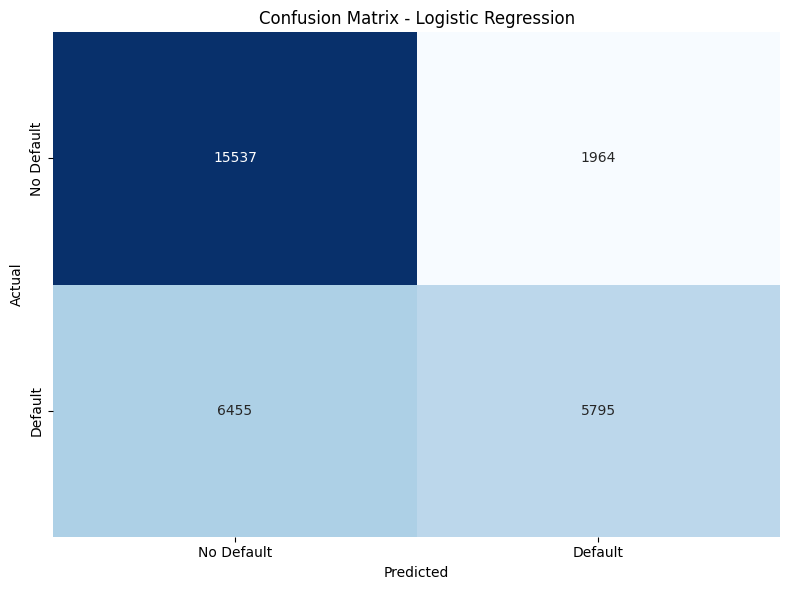

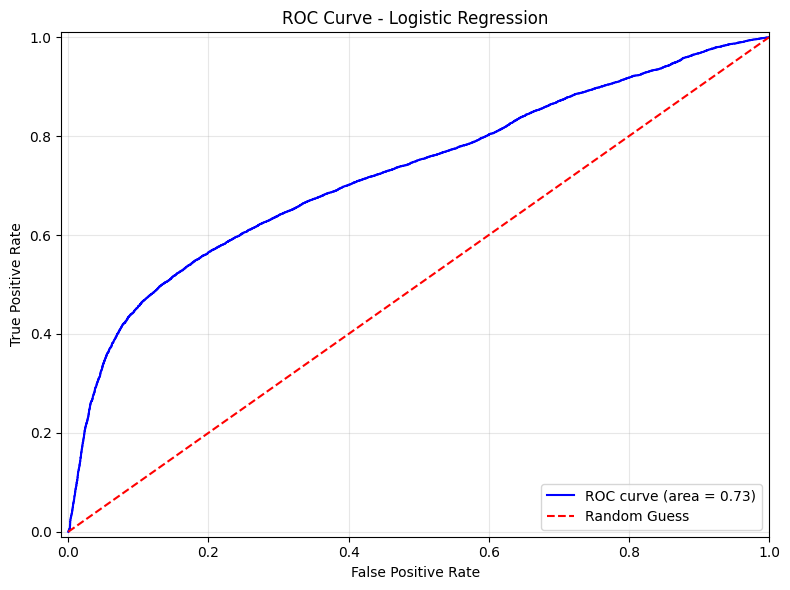

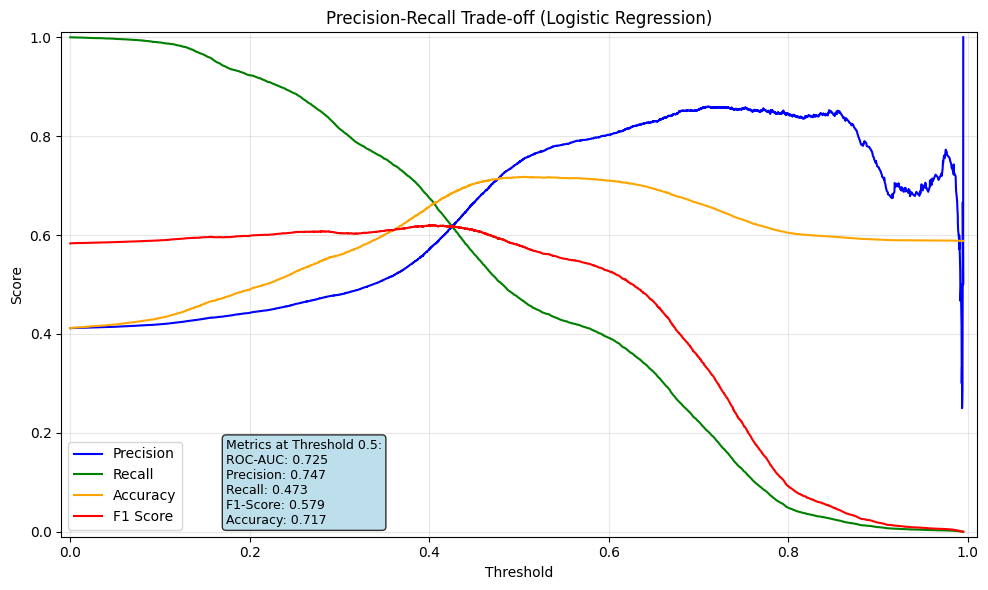

In [14]:
# Getting cross-validation predicted probabilities for positive (Default)class
y_pred_proba_cv_lr = cross_val_predict(logistic_model, X_train, y_train, cv=5, method='predict_proba')[:, 1]

# Plotting the confusion matrix
plot_confusion_matrix(cm_cv_lr, model_name='Logistic Regression', save_path=validation_performace_outputs)

# Plotting the ROC curve
plot_roc_curve(y_train, y_pred_proba_cv_lr, model_name='Logistic Regression', save_path=validation_performace_outputs)

# Plotting the Precision-Recall Trade-off
plot_precision_recall_tradeoff(y_train, y_pred_proba_cv_lr, y_pred_cv_lr, model_name='Logistic Regression', save_path=validation_performace_outputs)

- Logistic Regression performs well with Area Under ROC Curve (AUC) of 72.5% and F1 score of 0.57.9% on validation dataset.
- The model has a precision of 74.7%, which means that when the model predicts a default payment, it is correct 74.7% of the time.
- The recall is 47.3%, indicating that the model identifies 47.3% of actual default payments. which is very low and critical for this problem.

## **2.2 Decision Tree Classifier Model**

In [15]:
# Finding the best parameters for decision tree using GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Defining the parameter grid for GridSearchCV
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 15],
    'min_samples_split': [5, 7],
    'min_samples_leaf': [2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Creating a Decision Tree model
decision_tree_model = DecisionTreeClassifier(random_state=1)

# Performing GridSearchCV to find the best hyperparameters
grid_search_dt = GridSearchCV(decision_tree_model, param_grid_dt, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)
grid_search_dt.fit(X_train, y_train)

# Displaying the best hyperparameters
best_params_dt = grid_search_dt.best_params_
best_params_dt

Fitting 5 folds for each of 72 candidates, totalling 360 fits


{'criterion': 'gini',
 'max_depth': 15,
 'max_features': 'log2',
 'min_samples_leaf': 4,
 'min_samples_split': 5}

In [16]:
# Training the Decision Tree Classifier model on best hyperparameters
decision_tree_model = DecisionTreeClassifier(**best_params_dt, random_state=1)

# Getting cross-validation predictions
y_pred_cv_dt = cross_val_predict(decision_tree_model, X_train, y_train, cv=5)

# Calculating the cross-validation roc auc scores
cv_roc_auc_dt = cross_val_score(decision_tree_model, X_train, y_train, scoring='roc_auc', cv=5).round(4)
mean_cv_roc_auc_dt = np.mean(cv_roc_auc_dt)
print(f"\nCross-validation roc auc: {cv_roc_auc_dt}")
print(f"\nmean roc auc: {mean_cv_roc_auc_dt:.4f}")

# Calculating performance metrics for cross-validation
cm_cv_dt, precision_cv_dt, recall_cv_dt, f1_cv_dt, accuracy_cv_dt = calculate_performance_metrics(y_train, y_pred_cv_dt)
print(f"Precision: {precision_cv_dt:.4f}")
print(f"Recall: {recall_cv_dt:.4f}")
print(f"F1 Score: {f1_cv_dt:.4f}")
print(f"Accuracy: {accuracy_cv_dt:.4f}")
print(f"\nConfusion Matrix:\n{cm_cv_dt}")


Cross-validation roc auc: [0.7033 0.705  0.8436 0.8379 0.8549]

mean roc auc: 0.7889
Precision: 0.7211
Recall: 0.6189
F1 Score: 0.6661
Accuracy: 0.7445

Confusion Matrix:
[[14569  2932]
 [ 4669  7581]]


- **Better Recall Performance**: Decision Tree achieves 61.9% recall compared to Logistic Regression's 47.3%, meaning it captures more actual defaults. This improvement is crucial for identifying high-risk customers in credit default prediction.

- **Improved Overall Balance**: With 74% accuracy and 66.6% F1-score, the Decision Tree shows better balanced performance between precision (72.1%) and recall (61.9%) compared to Logistic Regression, making it more suitable for scenarios where catching defaults is prioritized while maintaining reasonable precision.

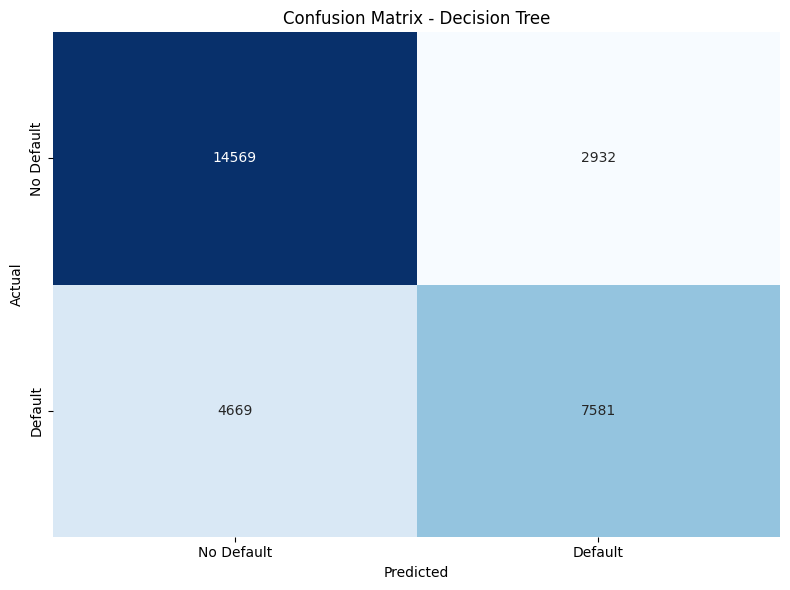

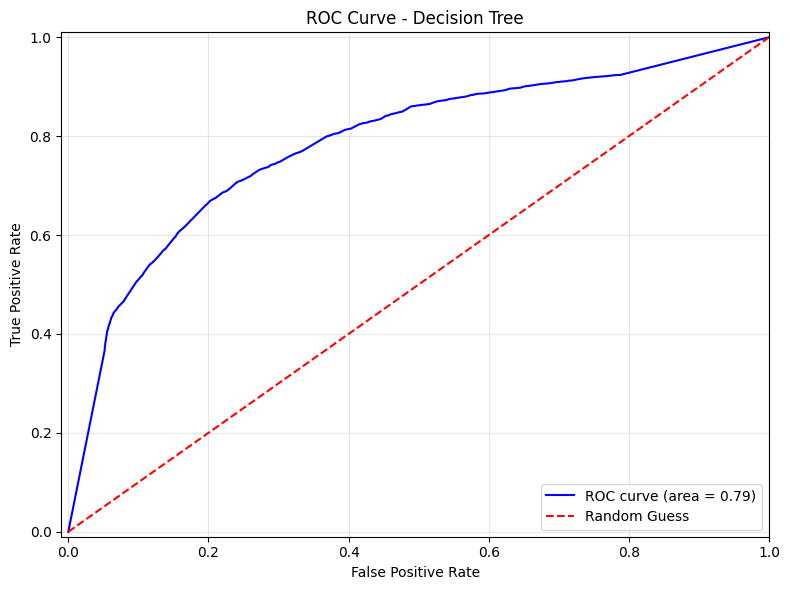

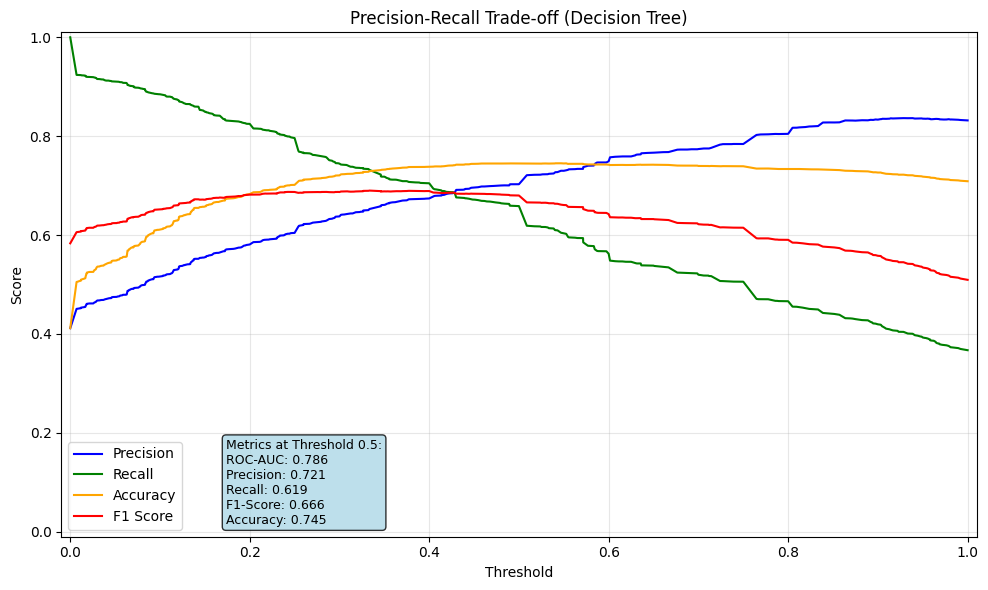

In [17]:
# Getting cross-validation predicted probabilities for positive (Default) class
y_pred_proba_cv_dt = cross_val_predict(decision_tree_model, X_train, y_train, cv=5, method='predict_proba')[:, 1]

# Plotting the confusion matrix
plot_confusion_matrix(cm_cv_dt, model_name='Decision Tree', save_path=validation_performace_outputs)

# Plotting the ROC curve
plot_roc_curve(y_train, y_pred_proba_cv_dt, model_name='Decision Tree', save_path=validation_performace_outputs)

# Plotting the Precision-Recall Trade-off
plot_precision_recall_tradeoff(y_train, y_pred_proba_cv_dt, y_pred_cv_dt, model_name='Decision Tree', save_path=validation_performace_outputs)

- Decision Tree Classifier performs well with Area Under ROC Curve (AUC) of 78.6% and F1 score of 66.6% on validation dataset.
- The model has a precision of 72.1%, which means that when the model predicts a default payment, it is correct 72.1% of the time.
- The recall is 61.9%, indicating that the model identifies 61.9% of actual default payments, which is significantly better than Logistic Regression's recall.

## **2.3 K-Nearest Neighbors (KNN) Model**

In [18]:
# Finding the best hyperparameters for K-Nearest Neighbors using GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Defining the parameter grid for GridSearchCV
param_grid_knn = {
    'n_neighbors': [5, 7, 10, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Creating a K-Nearest Neighbors Classifier model
knn_model = KNeighborsClassifier()

# Performing GridSearchCV to find the best hyperparameters
grid_search_knn = GridSearchCV(knn_model, param_grid_knn, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)
grid_search_knn.fit(X_train, y_train)

# Displaying the best hyperparameters
best_params_knn = grid_search_knn.best_params_
best_params_knn

Fitting 5 folds for each of 16 candidates, totalling 80 fits


{'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}

In [19]:
# Training the K-Nearest Neighbors model on best hyperparameters
knn_model = KNeighborsClassifier(**best_params_knn, n_jobs=-1)

# Getting cross-validation predictions
y_pred_cv_knn = cross_val_predict(knn_model, X_train, y_train, cv=5)

# Calculating the cross-validation roc auc scores
cv_roc_auc_knn = cross_val_score(knn_model, X_train, y_train, scoring='roc_auc', cv=5).round(4)
mean_cv_roc_auc_knn = np.mean(cv_roc_auc_knn)
print(f"Cross-validation roc auc: {cv_roc_auc_knn}")
print(f"\nmean roc auc: {mean_cv_roc_auc_knn:.4f}")

# Calculating performance metrics for cross-validation
cm_cv_knn, precision_cv_knn, recall_cv_knn, f1_cv_knn, accuracy_cv_knn = calculate_performance_metrics(y_train, y_pred_cv_knn)
print(f"Precision: {precision_cv_knn:.4f}")
print(f"Recall: {recall_cv_knn:.4f}")
print(f"F1 Score: {f1_cv_lr:.4f}")
print(f"Accuracy: {accuracy_cv_knn:.4f}")
print(f"\nConfusion Matrix:\n{cm_cv_knn}")

Cross-validation roc auc: [0.8733 0.8655 0.9247 0.9279 0.9344]

mean roc auc: 0.9052
Precision: 0.7336
Recall: 0.8811
F1 Score: 0.5792
Accuracy: 0.8193

Confusion Matrix:
[[13581  3920]
 [ 1457 10793]]


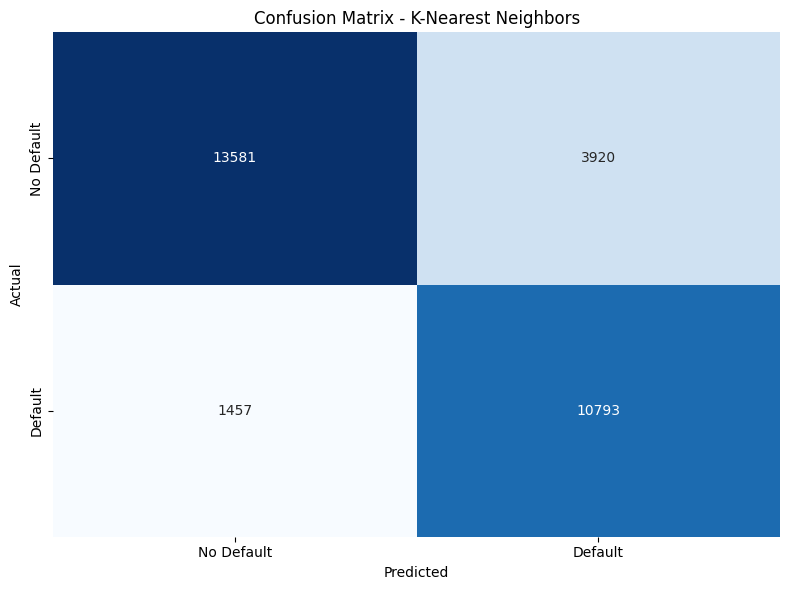

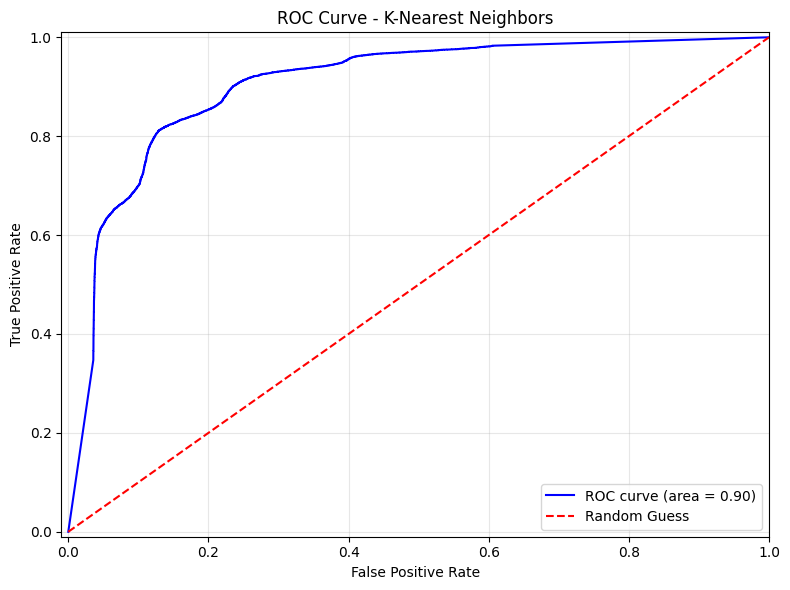

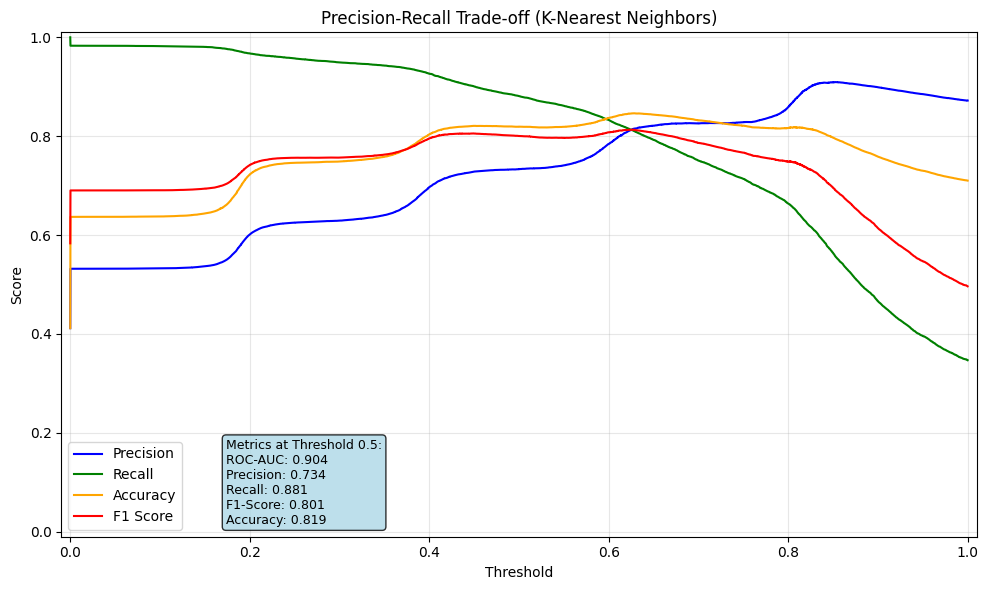

In [21]:
# Getting cross-validation predicted probabilities for positive (Default) class
y_pred_proba_cv_knn = cross_val_predict(knn_model, X_train, y_train, cv=5, method='predict_proba')[:, 1]

# Plotting the confusion matrix
plot_confusion_matrix(cm_cv_knn, model_name='K-Nearest Neighbors', save_path=validation_performace_outputs)

# Plotting the ROC curve
plot_roc_curve(y_train, y_pred_proba_cv_knn, model_name='K-Nearest Neighbors', save_path=validation_performace_outputs)

# Plotting the Precision-Recall Trade-off
plot_precision_recall_tradeoff(y_train, y_pred_proba_cv_knn, y_pred_cv_knn, model_name='K-Nearest Neighbors', save_path=validation_performace_outputs)

- KNN Classifier performs very well with Area Under ROC Curve (AUC) of 90.4% and F1 score of 80.1% on validation dataset.
- The model has a precision of 73.4%, which means that when the model predicts a default payment, it is correct 73.4% of the time.
- The recall is 88.1%, indicating that the model identifies 88.1% of actual default payments, which is significantly better than both Logistic Regression and Decision Tree Classifier.

## **2.4 Random Forest Classifier Model**

In [22]:
# Finding best parameters for Random Forest Classifier using GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Defining the parameter grid for GridSearchCV
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [5, 7],
    'min_samples_leaf': [2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Creating a Random Forest Classifier model
random_forest_model = RandomForestClassifier(random_state=1)

# Performing GridSearchCV to find the best hyperparameters
grid_search_rf = GridSearchCV(random_forest_model, param_grid_rf, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

# Displaying the best hyperparameters
best_params_rf = grid_search_rf.best_params_
best_params_rf

Fitting 5 folds for each of 108 candidates, totalling 540 fits


{'max_depth': 15,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 200}

In [23]:
# Training a Random Forest Classifier model on best hyperparameters
random_forest_model = RandomForestClassifier(**best_params_rf, n_jobs=-1, random_state=1)

# Getting cross-validation predictions
y_pred_cv_rf = cross_val_predict(random_forest_model, X_train, y_train, cv=5)

# Calculating the cross-validation roc auc scores
cv_roc_auc_rf = cross_val_score(random_forest_model, X_train, y_train, scoring='roc_auc', cv=5).round(4)
mean_cv_roc_auc_rf = np.mean(cv_roc_auc_rf)
print("Cross-validation roc auc:", cv_roc_auc_rf)
print(f"\nmean roc auc: {mean_cv_roc_auc_rf:.4f}")

# Calculating performance metrics for cross-validation
cm_cv_rf, precision_cv_rf, recall_cv_rf, f1_cv_rf, accuracy_cv_rf = calculate_performance_metrics(y_train, y_pred_cv_rf)
print(f"Precision: {precision_cv_rf:.4f}")
print(f"Recall: {recall_cv_rf:.4f}")
print(f"F1 Score: {f1_cv_rf:.4f}")
print(f"Accuracy: {accuracy_cv_rf:.4f}")
print(f"\nConfusion Matrix:\n{cm_cv_rf}")

Cross-validation roc auc: [0.8253 0.8287 0.9425 0.9411 0.9469]

mean roc auc: 0.8969
Precision: 0.8374
Recall: 0.7007
F1 Score: 0.7630
Accuracy: 0.8207

Confusion Matrix:
[[15834  1667]
 [ 3666  8584]]


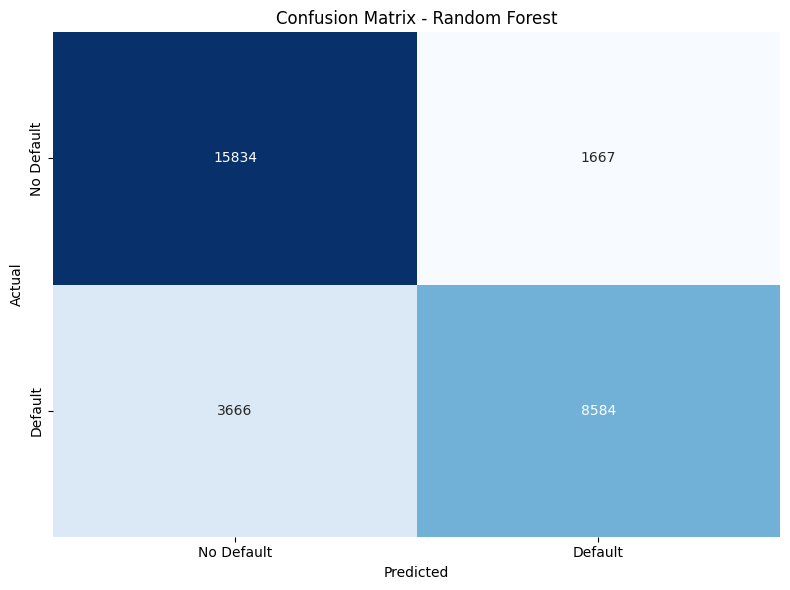

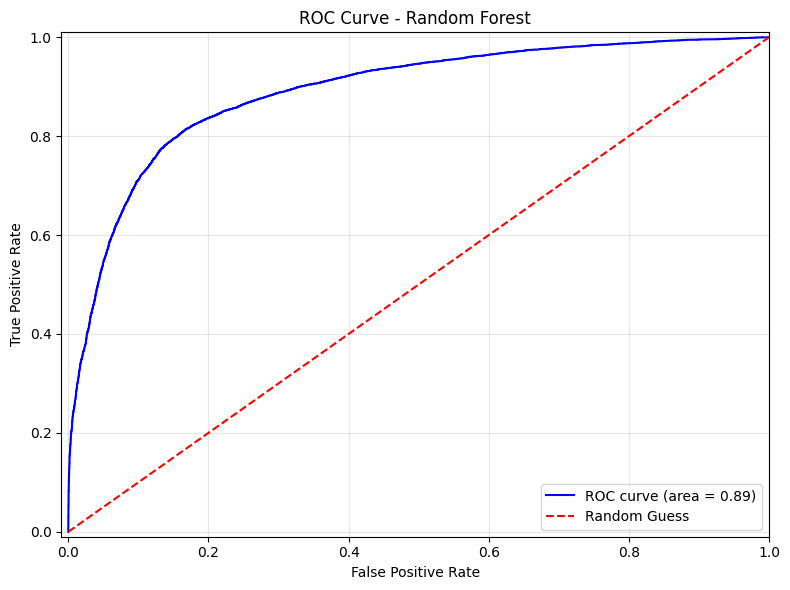

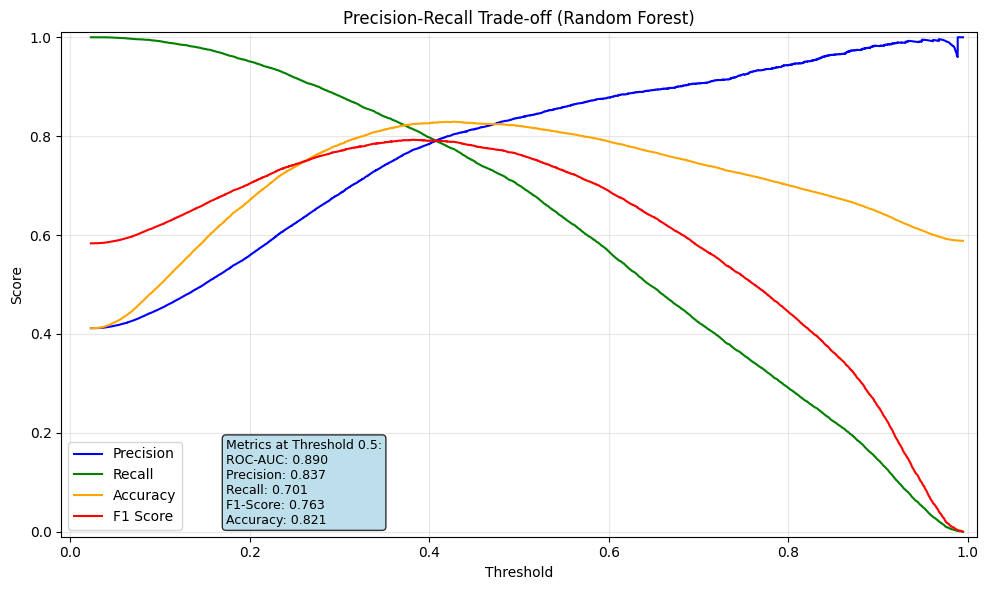

In [24]:
# Getting cross-validation predicted probabilities for positive (Default) class
y_pred_proba_cv_rf = cross_val_predict(random_forest_model, X_train, y_train, cv=5, method='predict_proba')[:, 1]

# Plotting the confusion matrix
plot_confusion_matrix(cm_cv_rf, model_name='Random Forest', save_path=validation_performace_outputs)

# Plotting the ROC curve
plot_roc_curve(y_train, y_pred_proba_cv_rf, model_name='Random Forest', save_path=validation_performace_outputs)

# Plotting the Precision-Recall Trade-off
plot_precision_recall_tradeoff(y_train, y_pred_proba_cv_rf, y_pred_cv_rf, model_name='Random Forest', save_path=validation_performace_outputs)

- Random Forest Classifier performs very well with Area Under ROC Curve (AUC) of 89% and F1 score of 76.3% on validation dataset.
- The model has a precision of 83.7%, which means that when the model predicts a default payment, it is correct 83.7% of the time.
- The recall is 70.1%, indicating that the model identifies 70.1% of actual default payments, which is significantly better than both Logistic Regression and Decision Tree Classifier.

## **2.5 AdaBoost Classifier Model**

In [25]:
# Finding the best hyperparameters for AdaBoost using GridSearchCV
from sklearn.ensemble import AdaBoostClassifier

# Defining the parameter grid for GridSearchCV
param_grid_ab = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1],
    'algorithm': ['SAMME', 'SAMME.R']
}

# Creating an AdaBoost Classifier model
ada_boost_model = AdaBoostClassifier(random_state=1)

# Performing GridSearchCV to find the best hyperparameters
grid_search_ab = GridSearchCV(ada_boost_model, param_grid_ab, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)
grid_search_ab.fit(X_train, y_train)

# Displaying the best hyperparameters
best_params_ab = grid_search_ab.best_params_
best_params_ab

Fitting 5 folds for each of 18 candidates, totalling 90 fits


{'algorithm': 'SAMME', 'learning_rate': 1, 'n_estimators': 200}

In [26]:
# Training an AdaBoost Classifier model on best hyperparameters
ada_boost_model = AdaBoostClassifier(**best_params_ab, random_state=1)

# Getting cross-validation predictions
y_pred_cv_ab = cross_val_predict(ada_boost_model, X_train, y_train, cv=5)

# Calculating the cross-validation roc auc scores
cv_roc_auc_ab = cross_val_score(ada_boost_model, X_train, y_train, cv=5, scoring='roc_auc').round(4)
mean_cv_roc_auc_ab = np.mean(cv_roc_auc_ab)
print(f"\nCross-validation roc auc: {cv_roc_auc_ab}")
print(f"\nmean roc auc: {mean_cv_roc_auc_ab:.4f}")

# Calculating performance metrics for cross-validation
cm_cv_ab, precision_cv_ab, recall_cv_ab, f1_cv_ab, accuracy_cv_ab = calculate_performance_metrics(y_train, y_pred_cv_ab)
print(f"Precision: {precision_cv_ab:.4f}")
print(f"Recall: {recall_cv_ab:.4f}")
print(f"F1 Score: {f1_cv_ab:.4f}")
print(f"Accuracy: {accuracy_cv_ab:.4f}")
print(f"\nConfusion Matrix:\n{cm_cv_ab}")


Cross-validation roc auc: [0.7707 0.7768 0.9103 0.9273 0.9202]

mean roc auc: 0.8611
Precision: 0.8305
Recall: 0.6144
F1 Score: 0.7063
Accuracy: 0.7896

Confusion Matrix:
[[15965  1536]
 [ 4724  7526]]


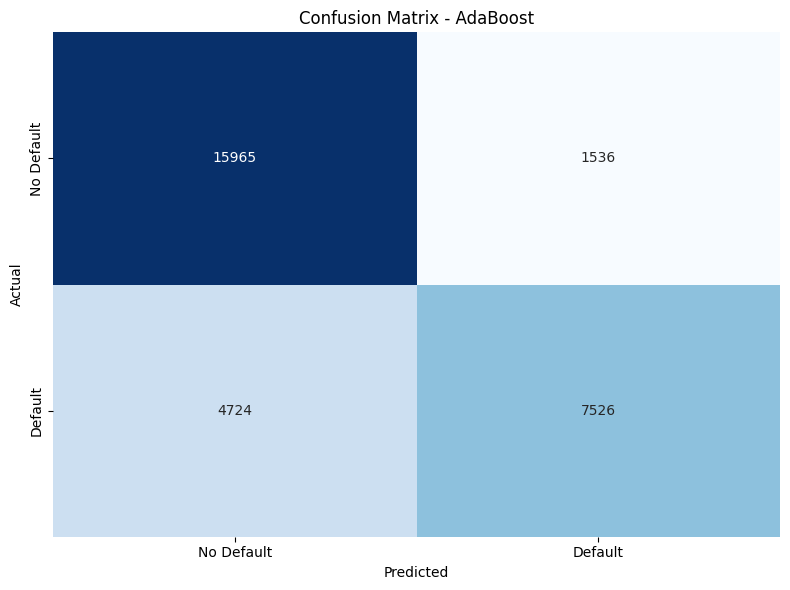

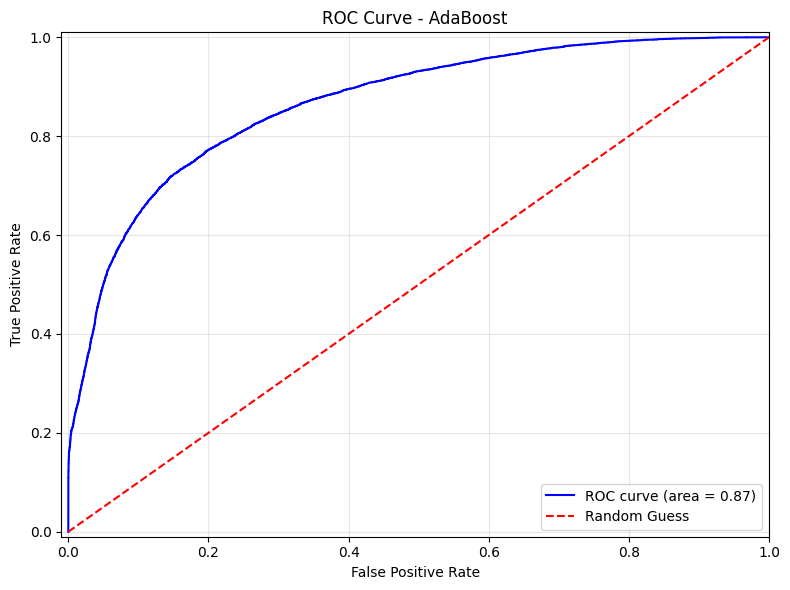

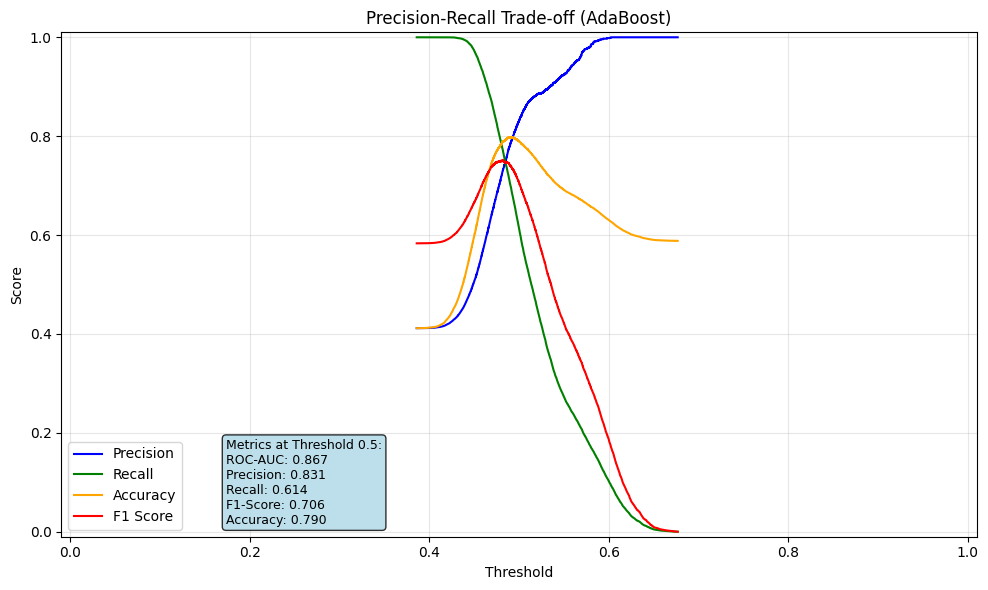

In [27]:
# Getting cross-validation predicted probabilities for positive (Default) class
y_pred_proba_cv_ab = cross_val_predict(ada_boost_model, X_train, y_train, cv=5, method='predict_proba')[:, 1]

# Plotting the confusion matrix
plot_confusion_matrix(cm_cv_ab, model_name='AdaBoost', save_path=validation_performace_outputs)

# Plotting the ROC curve
plot_roc_curve(y_train, y_pred_proba_cv_ab, model_name='AdaBoost', save_path=validation_performace_outputs)

# Plotting the Precision-Recall Trade-off
plot_precision_recall_tradeoff(y_train, y_pred_proba_cv_ab, y_pred_cv_ab, model_name='AdaBoost', save_path=validation_performace_outputs)

- AdaBoost Classifier performs well with Area Under ROC Curve (AUC) of 86.7% and F1 score of 70.6% on validation dataset.
- The model has a precision of 83.1%, which means that when the model predicts a default payment, it is correct 83.1% of the time.
- The recall is 61.4%, indicating that the model identifies 61.4% of actual default payments, which is better than Logistic Regression's recall but lower than Decision Tree and KNN.

## **2.6 Gradient Boosting Classifier Model**

In [28]:
# Finding the best parameters for Gradient Boosting Classifier using GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

# Defining the parameter grid for GridSearchCV
param_grid_gb = {
    'n_estimators': [100, 300],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7],
    'min_samples_split': [3, 5],
    'min_samples_leaf': [2, 4],
    'max_features': ['sqrt', 'log2']
}

# Creating a Gradient Boosting Classifier model
gradient_boosting_model = GradientBoostingClassifier(random_state=1)

# Performing GridSearchCV to find the best hyperparameters
grid_search_gb = GridSearchCV(gradient_boosting_model, param_grid_gb, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)
grid_search_gb.fit(X_train, y_train)

# Displaying the best hyperparameters
best_params_gb = grid_search_gb.best_params_
best_params_gb

Fitting 5 folds for each of 96 candidates, totalling 480 fits


{'learning_rate': 0.1,
 'max_depth': 7,
 'max_features': 'log2',
 'min_samples_leaf': 4,
 'min_samples_split': 3,
 'n_estimators': 300}

In [29]:
# Training a Gradient Boosting Classifier model on best hyperparameters
gradient_boosting_model = GradientBoostingClassifier(**best_params_gb, random_state=1)

# Getting cross-validation predictions
y_pred_cv_gb = cross_val_predict(gradient_boosting_model, X_train, y_train, cv=5)

# Calculating the cross-validation roc auc scores
cv_roc_auc_gb = cross_val_score(gradient_boosting_model, X_train, y_train, scoring='roc_auc', cv=5).round(4)
mean_cv_roc_auc_gb = np.mean(cv_roc_auc_gb)
print(f"Cross-validation roc auc:", cv_roc_auc_gb)
print(f"\nmean roc auc: {mean_cv_roc_auc_gb:.4f}")

# Calculating performance metrics for cross-validation
cm_cv_gb, precision_cv_gb, recall_cv_gb, f1_cv_gb, accuracy_cv_gb = calculate_performance_metrics(y_train, y_pred_cv_gb)
print(f"Precision: {precision_cv_gb:.4f}")
print(f"Recall: {recall_cv_gb:.4f}")
print(f"F1 Score: {f1_cv_gb:.4f}")
print(f"Accuracy: {accuracy_cv_gb:.4f}")
print(f"\nConfusion Matrix:\n{cm_cv_gb}")

Cross-validation roc auc: [0.8015 0.7971 0.9855 0.9913 0.9925]

mean roc auc: 0.9136
Precision: 0.8707
Recall: 0.7325
F1 Score: 0.7957
Accuracy: 0.8451

Confusion Matrix:
[[16169  1332]
 [ 3277  8973]]


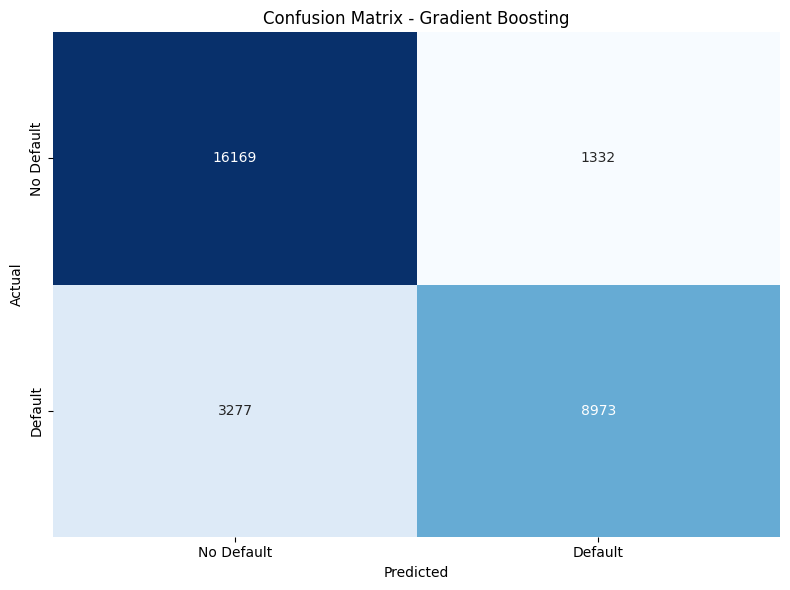

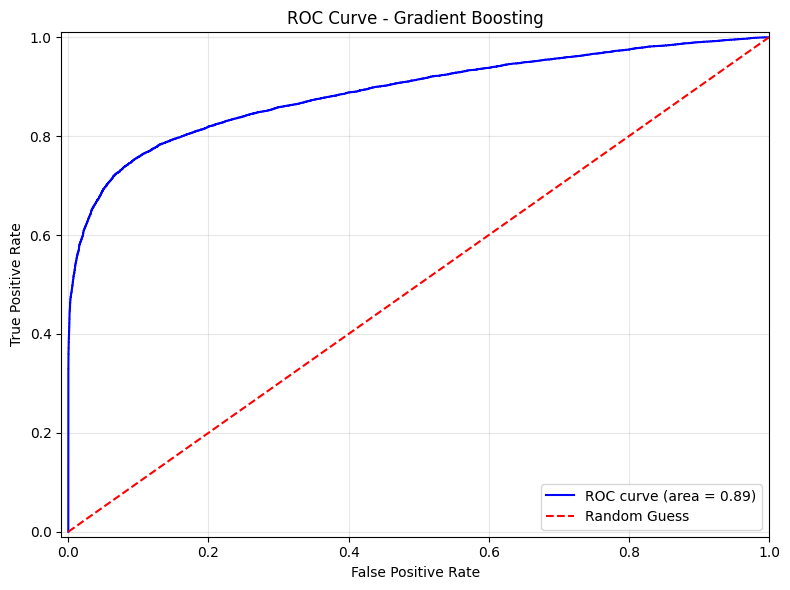

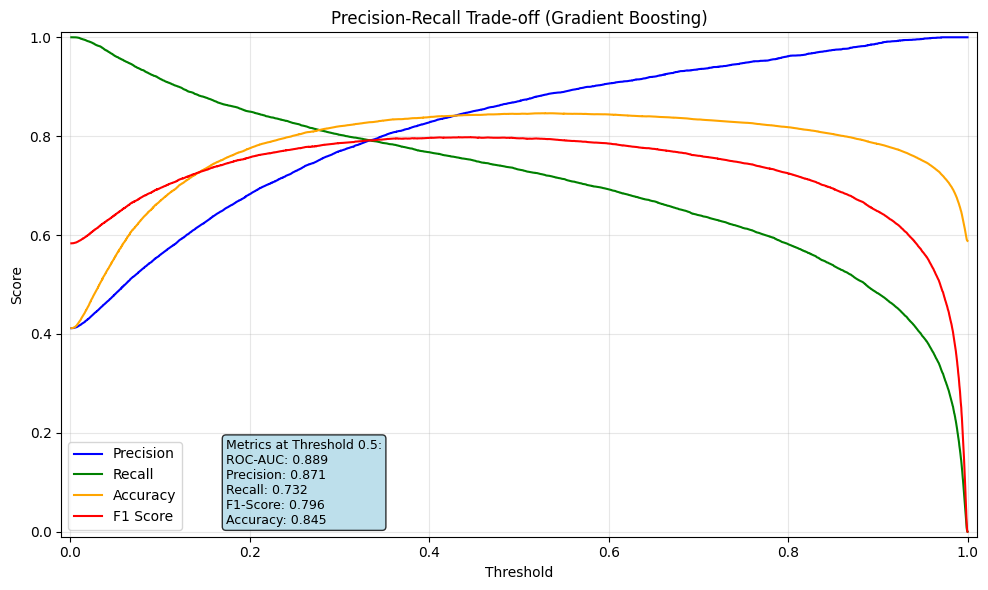

In [30]:
# Getting cross-validation predicted probabilities for positive (Default) class
y_pred_proba_cv_gb = cross_val_predict(gradient_boosting_model, X_train, y_train, cv=5, method='predict_proba')[:, 1]

# Plotting the confusion matrix
plot_confusion_matrix(cm_cv_gb, model_name='Gradient Boosting', save_path=validation_performace_outputs)

# Plotting the ROC curve
plot_roc_curve(y_train, y_pred_proba_cv_gb, model_name='Gradient Boosting', save_path=validation_performace_outputs)

# Plotting the Precision-Recall Trade-off
plot_precision_recall_tradeoff(y_train, y_pred_proba_cv_gb, y_pred_cv_gb, model_name='Gradient Boosting', save_path=validation_performace_outputs)

- Gradient Boosting Classifier performs very well with Area Under ROC Curve (AUC) of 88.9% and F1 score of 79.6% on validation dataset.
- The model has a precision of 87.1%, which means that when the model predicts a default payment, it is correct 87.1% of the time.
- The recall is 73.2%, indicating that the model identifies 73.2% of actual default payments, which is significantly better than both Logistic Regression and Decision Tree Classifier.

## **2.7 XGBoost Classifier Model**

In [31]:
# Finding the best parameters for XGBoost using GridSearchCV
from xgboost import XGBClassifier

# Defining the parameter grid for GridSearchCV
param_grid_xgb = {
    'n_estimators': [100, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'scale_pos_weight': [1, 2]
}

# Creating an XGBoost Classifier model
xgboost_model = XGBClassifier(random_state=1, use_label_encoder=False, eval_metric='logloss')

# Performing GridSearchCV to find the best hyperparameters
grid_search_xgb = GridSearchCV(xgboost_model, param_grid_xgb, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)

# Displaying the best hyperparameters
best_params_xgb = grid_search_xgb.best_params_
best_params_xgb

Fitting 5 folds for each of 96 candidates, totalling 480 fits


{'colsample_bytree': 0.8,
 'learning_rate': 0.1,
 'max_depth': 7,
 'n_estimators': 300,
 'scale_pos_weight': 2,
 'subsample': 0.8}

In [32]:
# Training a XGBoost Classifier model on best hyperparameters
xgboost_model = XGBClassifier(**best_params_xgb, random_state=1, use_label_encoder=False, eval_metric='logloss')

# Getting cross-validation predictions
y_pred_cv_xgb = cross_val_predict(xgboost_model, X_train, y_train, cv=5)

# Calculating the cross-validation roc auc scores
cv_roc_auc_xgb = cross_val_score(xgboost_model, X_train, y_train, scoring='roc_auc', cv=5).round(4)
mean_cv_roc_auc_xgb = np.mean(cv_roc_auc_xgb)
print(f"\nCross-validation roc auc: {cv_roc_auc_xgb}")
print(f"\nmean roc auc: {mean_cv_roc_auc_xgb:.4f}")

# Calculating performance metrics for cross-validation
cm_cv_xgb, precision_cv_xgb, recall_cv_xgb, f1_cv_xgb, accuracy_cv_xgb = calculate_performance_metrics(y_train, y_pred_cv_xgb)
print(f"Precision: {precision_cv_xgb:.4f}")
print(f"Recall: {recall_cv_xgb:.4f}")
print(f"F1 Score: {f1_cv_xgb:.4f}")
print(f"Accuracy: {accuracy_cv_xgb:.4f}")
print(f"\nConfusion Matrix:\n{cm_cv_xgb}")


Cross-validation roc auc: [0.7915 0.7902 0.9874 0.9937 0.9947]

mean roc auc: 0.9115
Precision: 0.8134
Recall: 0.7640
F1 Score: 0.7879
Accuracy: 0.8307

Confusion Matrix:
[[15354  2147]
 [ 2891  9359]]


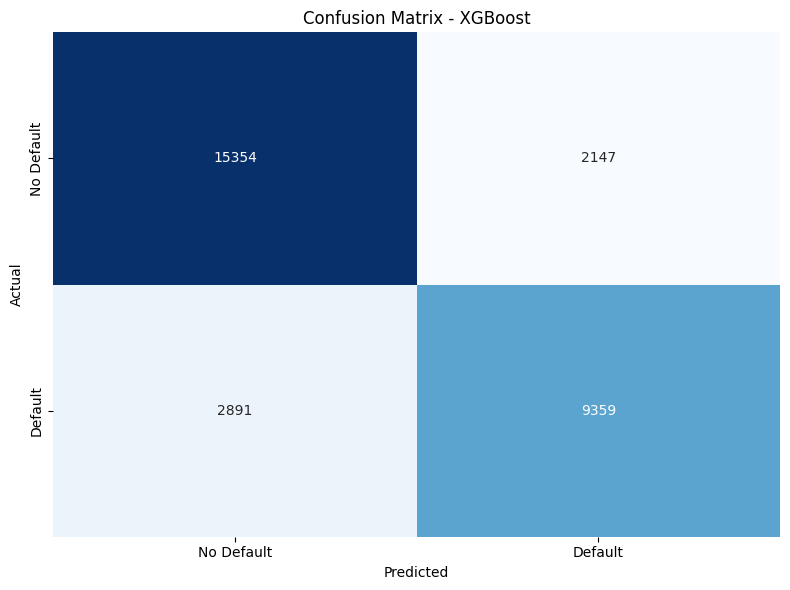

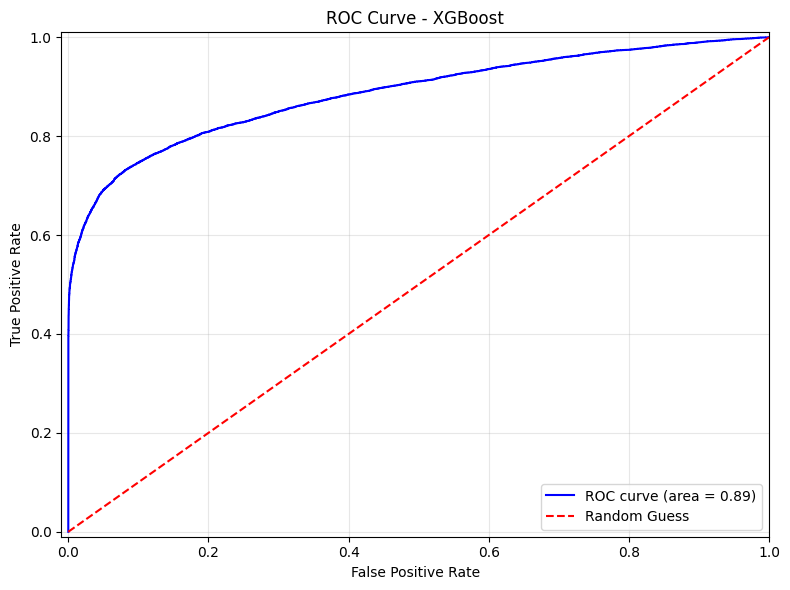

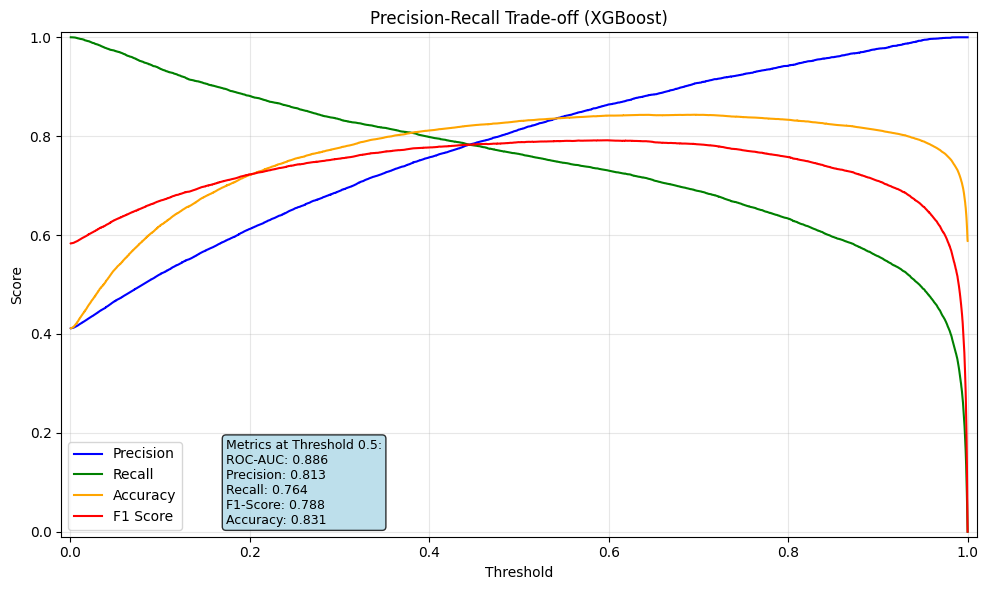

In [33]:
# Getting cross-validation predicted probabilities for positive (Default) class
y_pred_proba_cv_xgb = cross_val_predict(xgboost_model, X_train, y_train, cv=5, method='predict_proba')[:, 1]

# Plotting the confusion matrix
plot_confusion_matrix(cm_cv_xgb, model_name='XGBoost', save_path=validation_performace_outputs)

# Plotting the ROC curve
plot_roc_curve(y_train, y_pred_proba_cv_xgb, model_name='XGBoost', save_path=validation_performace_outputs)

# Plotting the Precision-Recall Trade-off
plot_precision_recall_tradeoff(y_train, y_pred_proba_cv_xgb, y_pred_cv_xgb, model_name='XGBoost', save_path=validation_performace_outputs)

- XGBoost Classifier performs very well with Area Under ROC Curve (AUC) of 88.6% and F1 score of 78.8% on validation dataset.
- The model has a precision of 81.3%, which means that when the model predicts a default payment, it is correct 81.3% of the time.
- The recall is 76.4%, indicating that the model identifies 76.4% of actual default payments, which is significantly better than both Logistic Regression and Decision Tree Classifier.

## **Performance comparison of all models**

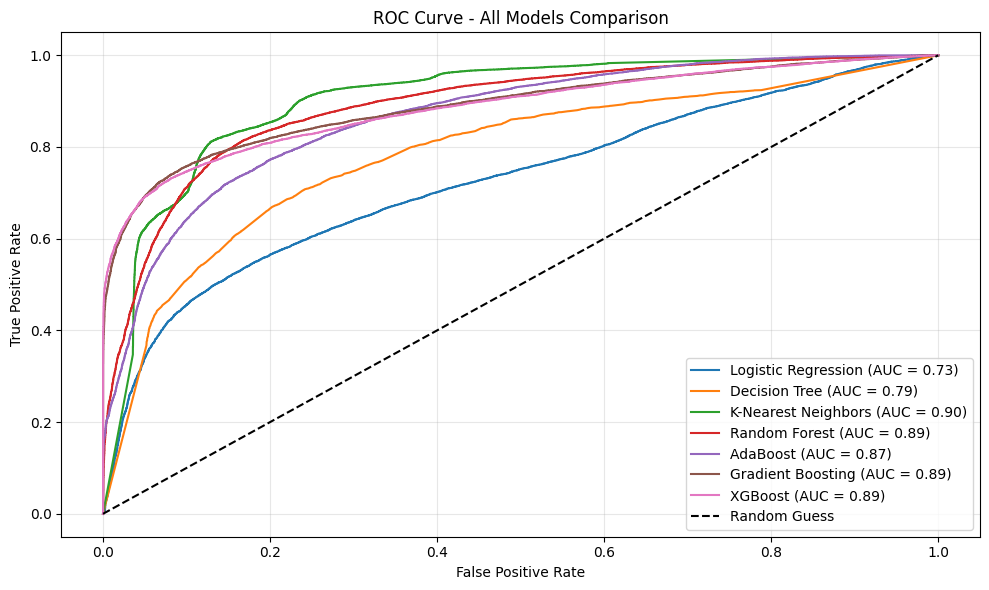

In [34]:
# Calculating fpr, tpr, and roc_auc for all models
fpr_cv_lr, tpr_cv_lr, roc_auc_cv_lr = calculate_roc_auc(y_train, y_pred_proba_cv_lr)
fpr_cv_dt, tpr_cv_dt, roc_auc_cv_dt = calculate_roc_auc(y_train, y_pred_proba_cv_dt)
fpr_cv_knn, tpr_cv_knn, roc_auc_cv_knn = calculate_roc_auc(y_train, y_pred_proba_cv_knn)
fpr_cv_rf, tpr_cv_rf, roc_auc_cv_rf = calculate_roc_auc(y_train, y_pred_proba_cv_rf)
fpr_cv_ab, tpr_cv_ab, roc_auc_cv_ab = calculate_roc_auc(y_train, y_pred_proba_cv_ab)
fpr_cv_gb, tpr_cv_gb, roc_auc_cv_gb = calculate_roc_auc(y_train, y_pred_proba_cv_gb)
fpr_cv_xgb, tpr_cv_xgb, roc_auc_cv_xgb = calculate_roc_auc(y_train, y_pred_proba_cv_xgb)


# Ploting ROC AUC for all models
plt.figure(figsize=(10, 6))
plt.plot(fpr_cv_lr, tpr_cv_lr, label=f'Logistic Regression (AUC = {roc_auc_cv_lr:.2f})')
plt.plot(fpr_cv_dt, tpr_cv_dt, label=f'Decision Tree (AUC = {roc_auc_cv_dt:.2f})')
plt.plot(fpr_cv_knn, tpr_cv_knn, label=f'K-Nearest Neighbors (AUC = {roc_auc_cv_knn:.2f})')
plt.plot(fpr_cv_rf, tpr_cv_rf, label=f'Random Forest (AUC = {roc_auc_cv_rf:.2f})')
plt.plot(fpr_cv_ab, tpr_cv_ab, label=f'AdaBoost (AUC = {roc_auc_cv_ab:.2f})')    
plt.plot(fpr_cv_gb, tpr_cv_gb, label=f'Gradient Boosting (AUC = {roc_auc_cv_gb:.2f})')
plt.plot(fpr_cv_xgb, tpr_cv_xgb, label=f'XGBoost (AUC = {roc_auc_cv_xgb:.2f})')
plt.plot([0, 1], [0, 1], color='black', linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - All Models Comparison')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(validation_performace_outputs, "roc_curve_comparison.png"))
plt.show()

- Based on the Area Under ROC Curve (AUC) scores, the KNN Classifier (90%), Random Forest Classifier (89%) models , Gradient Boosting Classifier (89%) and XGBoost Classifier (89%) performed the best. followed closely by AdaBoost Classifier (86.7%).

In [35]:
# Creating a summary dataframe for model performance
model_performance = {
    'Model': ['Logistic Regression', 'Decision Tree', 'K-Nearest Neighbors', 
              'Random Forest', 'AdaBoost', 'Gradient Boosting', 'XGBoost'],
    'ROC AUC': [roc_auc_cv_lr, roc_auc_cv_dt, roc_auc_cv_knn, 
                roc_auc_cv_rf, roc_auc_cv_ab, roc_auc_cv_gb, roc_auc_cv_xgb],
    'Precision': [precision_cv_lr, precision_cv_dt, precision_cv_knn,
                    precision_cv_rf, precision_cv_ab, precision_cv_gb, precision_cv_xgb],
    'Recall': [recall_cv_lr, recall_cv_dt, recall_cv_knn,
                recall_cv_rf, recall_cv_ab, recall_cv_gb, recall_cv_xgb],
    'F1 Score': [f1_cv_lr, f1_cv_dt, f1_cv_knn,
                    f1_cv_rf, f1_cv_ab, f1_cv_gb, f1_cv_xgb],
    'Accuracy': [accuracy_cv_lr, accuracy_cv_dt, accuracy_cv_knn,
                    accuracy_cv_rf, accuracy_cv_ab, accuracy_cv_gb, accuracy_cv_xgb]
}

model_performance_df = pd.DataFrame(model_performance)
model_performance_df = model_performance_df.sort_values(by='ROC AUC', ascending=False, ignore_index=True)

# Saving the model performance summary to a CSV file
csv_output_dir = "csv_outputs"
os.makedirs(csv_output_dir, exist_ok=True)
model_performance_df.to_csv(os.path.join(csv_output_dir, "model_performance_summary_validation.csv"), index=False)

# Displaying the model performance summary
model_performance_df

,Model,ROC AUC,Precision,Recall,F1 Score,Accuracy
0,K-Nearest Neighbors,0.903954,0.733569,0.881061,0.800579,0.819267
1,Random Forest,0.889993,0.837382,0.700735,0.762988,0.820746
2,Gradient Boosting,0.889197,0.870742,0.732490,0.795655,0.845081
3,XGBoost,0.885826,0.813402,0.764000,0.787927,0.830661
4,AdaBoost,0.866795,0.830501,0.614367,0.706269,0.789587
5,Decision Tree,0.786165,0.721107,0.618857,0.666081,0.744513
6,Logistic Regression,0.725320,0.746875,0.473061,0.579239,0.717018


- Based on the model performance on validation data, we will select **KNN Classifier**, **Random Forest Classifier**, **Gradient Boosting Classifier**, and **XGBoost Classifier** and try to test them on the test dataset to see how they perform on unseen data.
- As these models have shown the best performance in terms of AUC, Recall, , and F1 score, they are likely to generalize well to new data.

# **3. Model Evaluation**

In [36]:
# Defining the path to the CSV output directory for test performance outputs
test_performace_outputs = "test_performance_outputs"
os.makedirs(test_performace_outputs, exist_ok=True)

## **3.1 Loading Test Data**

In [37]:
# # Defining the path to the CSV output directory
csv_output_dir = "csv_outputs"
os.makedirs(test_performace_outputs, exist_ok=True)
# Loading the training data
test_data_path = os.path.join(csv_output_dir, "test_data.csv")

# Reading the training data into a DataFrame
test_data = pd.read_csv(train_data_path)

# Displaying the first few rows of the training data
test_data.head()

,Credit_Limit,Education_Level,Sept_Pay,Aug_Pay,July_Pay,June_Pay,May_Pay,Apr_Pay,Sept_Bill_Amt,Aug_Bill_Amt,...,Apr_Pay_Bill_Ratio,Avg_Pay_Bill_Ratio,Sept_Credit_Utilization_Ratio,Aug_Credit_Utilization_Ratio,July_Credit_Utilization_Ratio,June_Credit_Utilization_Ratio,May_Credit_Utilization_Ratio,Apr_Credit_Utilization_Ratio,Avg_Credit_Utilization_Ratio,default_payment_next_month
0,-0.286942,0.308263,0.010580,0.108000,0.137993,0.192481,0.239828,0.259337,-0.452249,-0.461789,...,0.008450,0.018362,-0.250428,-0.257562,-0.301519,-0.158567,-0.164245,-0.259512,-0.348635,0
1,-0.826903,0.308263,1.791635,1.781855,1.820638,1.918243,0.239828,0.259337,-0.148335,-0.111258,...,0.007773,0.017899,-0.150985,-0.108932,-0.407383,-0.059798,-0.052211,-0.058064,-0.348635,1
2,-0.672629,1.684695,0.010580,0.108000,0.137993,0.192481,0.239828,0.259337,-0.091411,-0.078527,...,0.007547,0.018131,-0.250428,0.559906,-0.195655,-0.158567,-0.164245,-0.158788,0.018175,0
3,1.178667,0.308263,-0.879947,-0.728927,-1.544652,-1.533282,-1.541873,-1.495054,-0.196536,-0.288899,...,0.050901,0.027323,0.445672,-0.034616,-0.301519,-0.059798,-0.164245,0.042660,0.018175,0
4,-0.364079,0.308263,-0.879947,0.108000,0.137993,0.192481,0.239828,0.259337,0.834479,0.917161,...,0.006870,0.017744,-0.150985,-0.034616,-0.195655,-0.257335,-0.388313,-0.360236,-0.348635,0


## **3.2 Splitting X_test and y_test**

In [38]:
# Splitting the data into X_test and y_test
X_test = test_data.drop(columns=['default_payment_next_month'])
y_test = test_data['default_payment_next_month']

# Displaying the shapes of X_train and y_train
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

X_test: (22473, 41)
y_test: (22473,)


In [39]:
X_test.head()

,Credit_Limit,Education_Level,Sept_Pay,Aug_Pay,July_Pay,June_Pay,May_Pay,Apr_Pay,Sept_Bill_Amt,Aug_Bill_Amt,...,May_Pay_Bill_Ratio,Apr_Pay_Bill_Ratio,Avg_Pay_Bill_Ratio,Sept_Credit_Utilization_Ratio,Aug_Credit_Utilization_Ratio,July_Credit_Utilization_Ratio,June_Credit_Utilization_Ratio,May_Credit_Utilization_Ratio,Apr_Credit_Utilization_Ratio,Avg_Credit_Utilization_Ratio
0,-0.286942,0.308263,0.010580,0.108000,0.137993,0.192481,0.239828,0.259337,-0.452249,-0.461789,...,0.013111,0.008450,0.018362,-0.250428,-0.257562,-0.301519,-0.158567,-0.164245,-0.259512,-0.348635
1,-0.826903,0.308263,1.791635,1.781855,1.820638,1.918243,0.239828,0.259337,-0.148335,-0.111258,...,0.011626,0.007773,0.017899,-0.150985,-0.108932,-0.407383,-0.059798,-0.052211,-0.058064,-0.348635
2,-0.672629,1.684695,0.010580,0.108000,0.137993,0.192481,0.239828,0.259337,-0.091411,-0.078527,...,0.011626,0.007547,0.018131,-0.250428,0.559906,-0.195655,-0.158567,-0.164245,-0.158788,0.018175
3,1.178667,0.308263,-0.879947,-0.728927,-1.544652,-1.533282,-1.541873,-1.495054,-0.196536,-0.288899,...,0.021724,0.050901,0.027323,0.445672,-0.034616,-0.301519,-0.059798,-0.164245,0.042660,0.018175
4,-0.364079,0.308263,-0.879947,0.108000,0.137993,0.192481,0.239828,0.259337,0.834479,0.917161,...,0.011032,0.006870,0.017744,-0.150985,-0.034616,-0.195655,-0.257335,-0.388313,-0.360236,-0.348635


In [40]:
y_test.head()

0    0
1    1
2    0
3    0
4    0
Name: default_payment_next_month, dtype: int64

## **3.3 Testing KNN Classifier Model**

In [41]:
best_params_knn

{'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}

In [42]:
# Training the K-Nearest Neighbors model on best hyperparameters
knn_model = KNeighborsClassifier(metric='manhattan', n_neighbors=5, 
                                 weights='distance', n_jobs=-1)

# Fitting the K-Nearest Neighbors model on the training data
knn_model.fit(X_train, y_train)

# Making predictions on the test set
y_pred_knn = knn_model.predict(X_test)

# Calculating performance metrics for the KNN Classifier on the test set
cm_knn, precision_knn, recall_knn, f1_knn, accuracy_knn = calculate_performance_metrics(y_test, y_pred_knn)
print(f"Precision: {precision_knn:.4f}")
print(f"Recall: {recall_knn:.4f}")
print(f"F1 Score: {f1_knn:.4f}")
print(f"Accuracy: {accuracy_knn:.4f}")
print(f"\nConfusion Matrix:\n{cm_knn}")

Precision: 0.9990
Recall: 0.9932
F1 Score: 0.9961
Accuracy: 0.9983

Confusion Matrix:
[[17496     5]
 [   34  4938]]


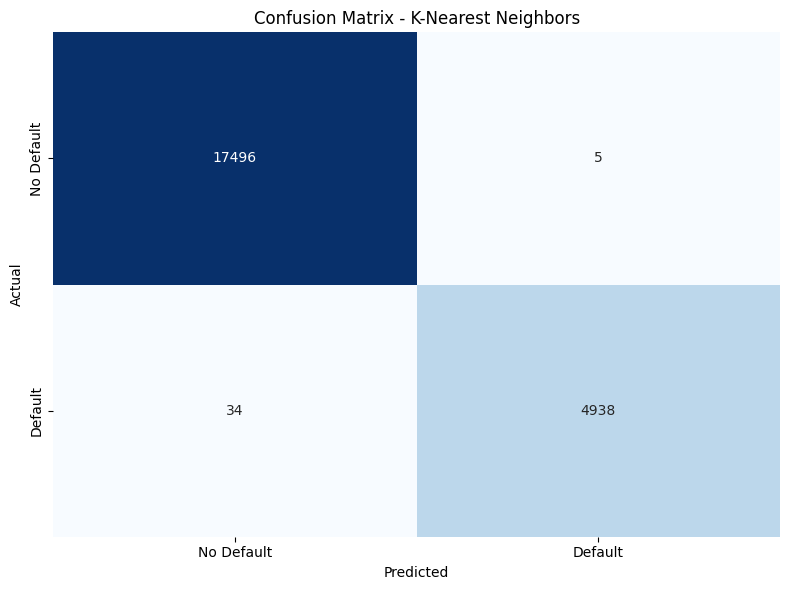

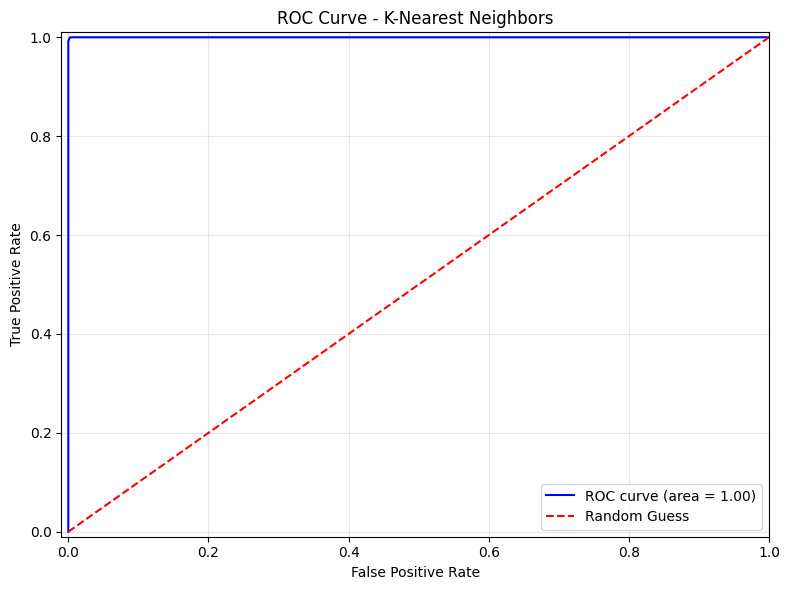

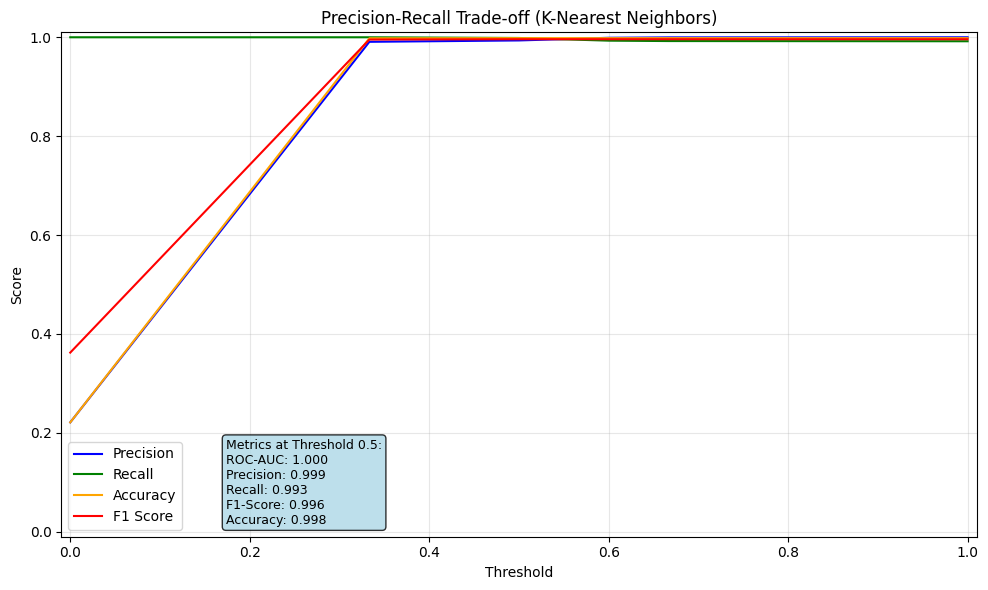

In [43]:
# Getting predicted probabilities for positive (Default) class
y_pred_proba_knn = knn_model.predict_proba(X_test)[:, 1]

# Plotting the confusion matrix for KNN Classifier
plot_confusion_matrix(cm_knn, model_name='K-Nearest Neighbors', save_path=test_performace_outputs)

# Plotting the ROC curve for KNN Classifier
plot_roc_curve(y_test, y_pred_proba_knn, model_name='K-Nearest Neighbors', save_path=test_performace_outputs)

# Plotting the Precision-Recall Trade-off for KNN Classifier
plot_precision_recall_tradeoff(y_test, y_pred_proba_knn, y_pred_knn, model_name='K-Nearest Neighbors', save_path=test_performace_outputs)

- The performance of KNN Classifier on test dataset is perfect with Area Under ROC Curve (AUC) of 100% and F1 score of 99.6% which is significantly better than validation dataset performance.
- The model has a precision of 99.9%, which means that when the model predicts a default payment, it is correct 99.9% of the time.
- The recall is 99.3%, indicating that the model identifies 99.3% of actual default payments, which is significantly better than validation dataset performance.
- The models performance on test dataset is significantly better than validation dataset performance, which indicates that the model has generalized well to unseen data.

## **3.4 Testing Random Forest Classifier Model**

In [44]:
best_params_rf

{'max_depth': 15,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 200}

In [45]:
# Training the Random Forest model on best hyperparameters
rf_model = RandomForestClassifier(max_depth=15, max_features='sqrt', 
                                  min_samples_leaf=2, min_samples_split=5, 
                                  n_estimators=200, n_jobs=-1, random_state=1)

# Fitting the Random Forest model on the training data
rf_model.fit(X_train, y_train)

# Making predictions on the test set
y_pred_rf = rf_model.predict(X_test)

# Calculating performance metrics for the Random Forest Classifier on the test set
cm_rf, precision_rf, recall_rf, f1_rf, accuracy_rf = calculate_performance_metrics(y_test, y_pred_rf)
print(f"Precision: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print(f"F1 Score: {f1_rf:.4f}")
print(f"Accuracy: {accuracy_rf:.4f}")
print(f"\nConfusion Matrix:\n{cm_rf}")

Precision: 0.8622
Recall: 0.6985
F1 Score: 0.7718
Accuracy: 0.9086

Confusion Matrix:
[[16946   555]
 [ 1499  3473]]


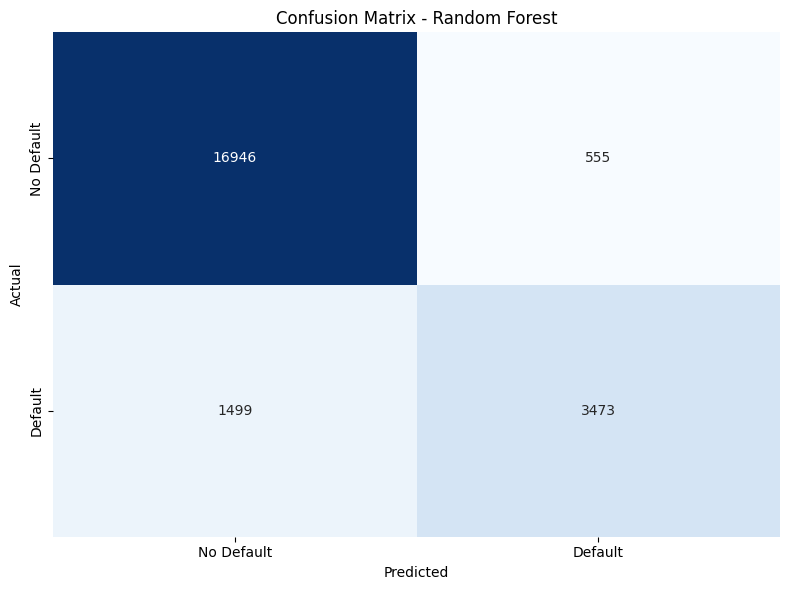

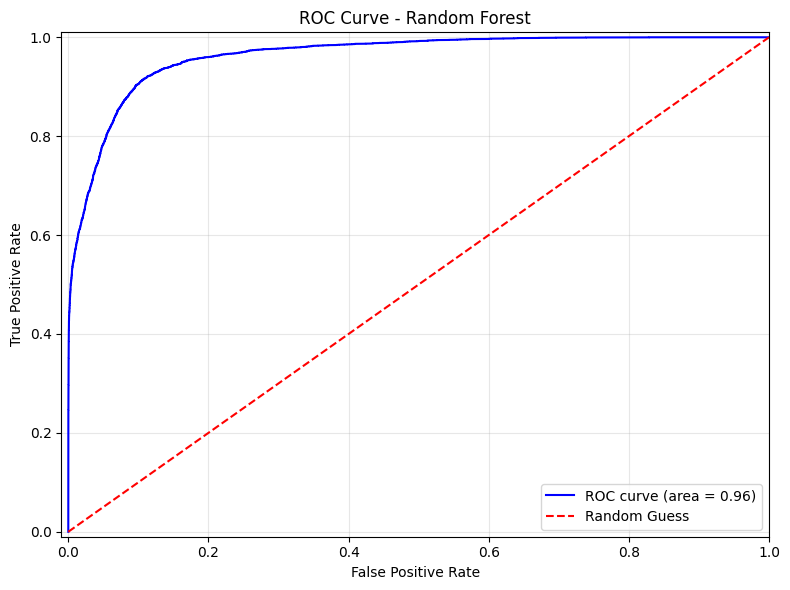

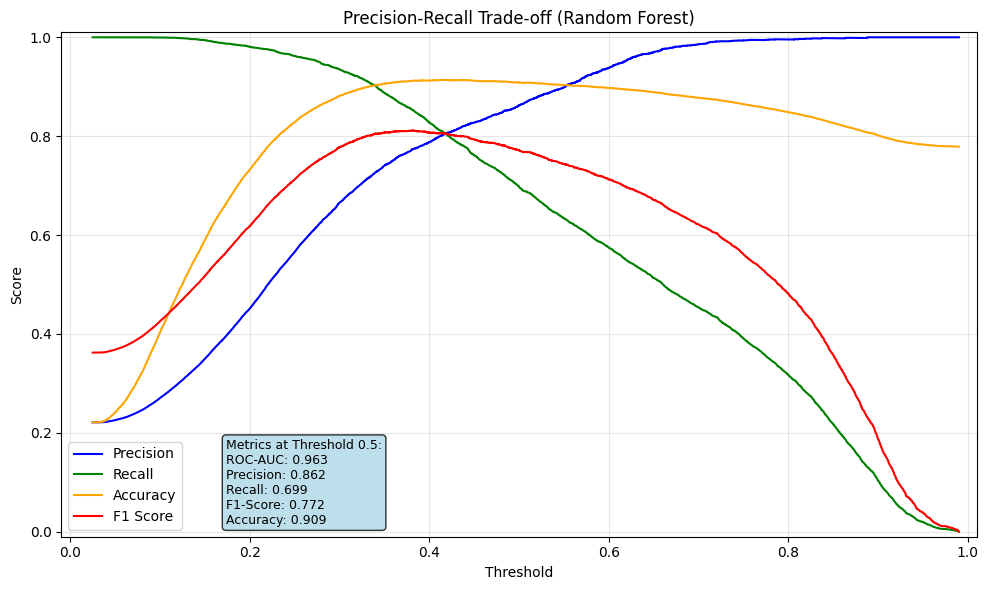

In [55]:
# Getting predicted probabilities for positive (Default) class
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Plotting the confusion matrix for Random Forest Classifier
plot_confusion_matrix(cm_rf, model_name='Random Forest', save_path=test_performace_outputs)

# Plotting the ROC curve for Random Forest Classifier
plot_roc_curve(y_test, y_pred_proba_rf, model_name='Random Forest', save_path=test_performace_outputs)

# Plotting the Precision-Recall Trade-off for Random Forest Classifier
plot_precision_recall_tradeoff(y_test, y_pred_proba_rf, y_pred_rf, model_name='Random Forest', save_path=test_performace_outputs)

- Random Forest Classifier performs well with Area Under ROC Curve (AUC) of 96.3% and F1 score of 77.2% on test dataset.
- The model has a precision of 86.2% which is good, but recall of 70%, indicating that the model identifies 70% of actual default payments, which is significantly less compared to KNN Classifier.

## **3.5 Testing Gradient Boosting Classifier Model**

In [47]:
best_params_gb

{'learning_rate': 0.1,
 'max_depth': 7,
 'max_features': 'log2',
 'min_samples_leaf': 4,
 'min_samples_split': 3,
 'n_estimators': 300}

In [48]:
# Training the Gradient Boosting model on best hyperparameters
gb_model = GradientBoostingClassifier(learning_rate=0.1, max_depth=7,
                                      max_features='log2', min_samples_leaf=4, 
                                      min_samples_split=3, n_estimators=300, random_state=1)

# Fitting the Gradient Boosting model on the training data
gb_model.fit(X_train, y_train)

# Making predictions on the test set
y_pred_gb = gb_model.predict(X_test)

# Calculating performance metrics for the Gradient Boosting Classifier on the test set
cm_gb, precision_gb, recall_gb, f1_gb, accuracy_gb = calculate_performance_metrics(y_test, y_pred_gb)
print(f"Precision: {precision_gb:.4f}")
print(f"Recall: {recall_gb:.4f}")
print(f"F1 Score: {f1_gb:.4f}")
print(f"Accuracy: {accuracy_gb:.4f}")
print(f"\nConfusion Matrix:\n{cm_gb}")

Precision: 0.9183
Recall: 0.7325
F1 Score: 0.8149
Accuracy: 0.9264

Confusion Matrix:
[[17177   324]
 [ 1330  3642]]


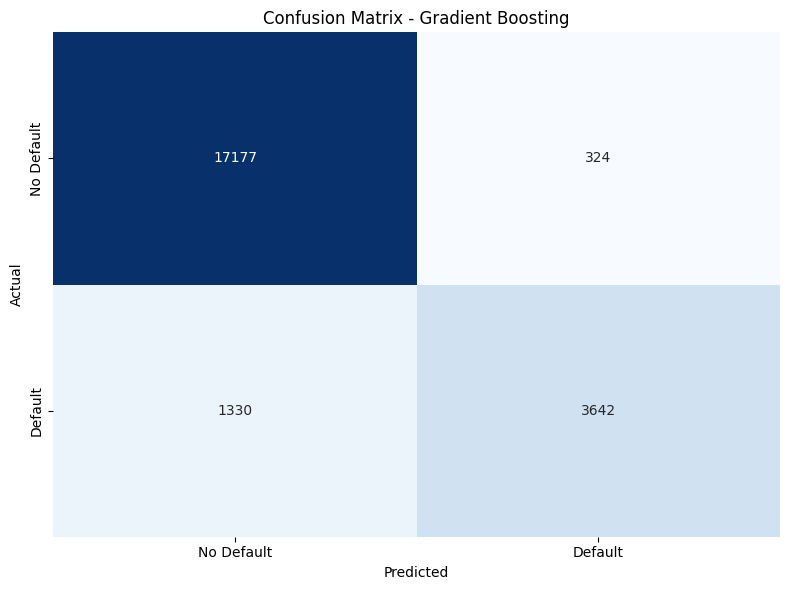

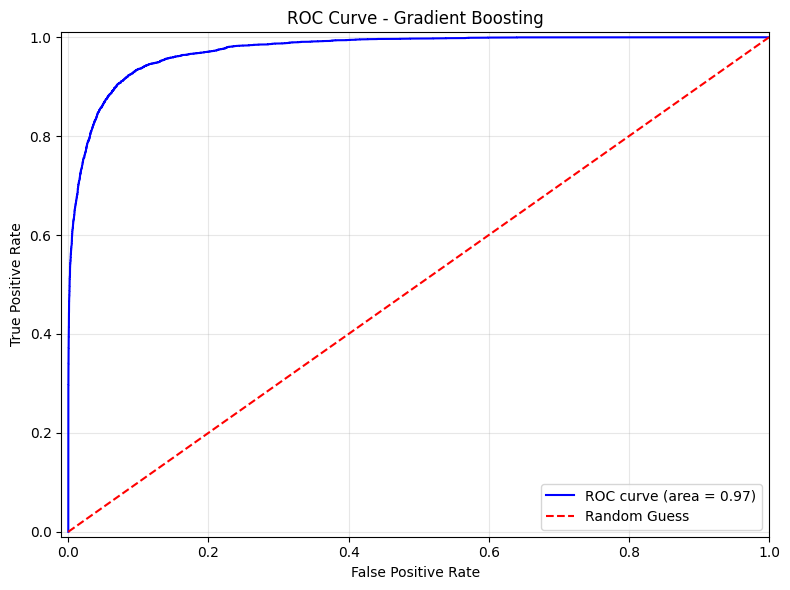

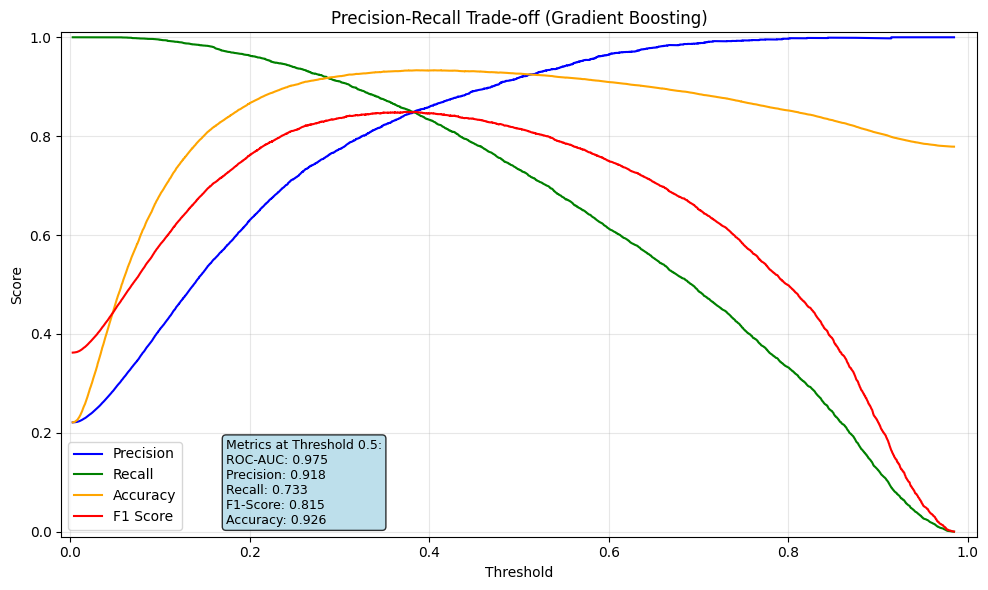

In [49]:
# Getting predicted probabilities for positive (Default) class
y_pred_proba_gb = gb_model.predict_proba(X_test)[:, 1]

# Plotting the confusion matrix for Gradient Boosting Classifier
plot_confusion_matrix(cm_gb, model_name='Gradient Boosting', save_path=test_performace_outputs)

# Plotting the ROC curve for Gradient Boosting Classifier
plot_roc_curve(y_test, y_pred_proba_gb, model_name='Gradient Boosting', save_path=test_performace_outputs)

# Plotting the Precision-Recall Trade-off for Gradient Boosting Classifier
plot_precision_recall_tradeoff(y_test, y_pred_proba_gb, y_pred_gb, model_name='Gradient Boosting', save_path=test_performace_outputs)

- Gradient Boosting Classifier performs very well with Area Under ROC Curve (AUC) of 97.5% and F1 score of 81.5% on test dataset.
- The model has a precision of 91.8%, which means that when the model predicts a default payment, it is correct 91.8% of the time.
- The recall is 73.3%, indicating that the model identifies 73.3% of actual default payments, which is significantly less compared to KNN Classifier but slightly better than Random Forest Classifier.

## **3.6 Testing XGBoost Classifier Model**

In [50]:
best_params_xgb

{'colsample_bytree': 0.8,
 'learning_rate': 0.1,
 'max_depth': 7,
 'n_estimators': 300,
 'scale_pos_weight': 2,
 'subsample': 0.8}

In [51]:
# Training the XGBoost model on best hyperparameters
xgb_model = XGBClassifier(colsample_bytree=0.8, learning_rate=0.1, max_depth=7, 
                          n_estimators=300, scale_pos_weight=2, subsample=0.8, 
                          random_state=1, use_label_encoder=False, eval_metric='logloss')

# Fitting the XGBoost model on the training data
xgb_model.fit(X_train, y_train)

# Making predictions on the test set
y_pred_xgb = xgb_model.predict(X_test)

# Calculating performance metrics for the XGBoost Classifier on the test set
cm_xgb, precision_xgb, recall_xgb, f1_xgb, accuracy_xgb = calculate_performance_metrics(y_test, y_pred_xgb)
print(f"Precision: {precision_xgb:.4f}")
print(f"Recall: {recall_xgb:.4f}")
print(f"F1 Score: {f1_xgb:.4f}")
print(f"Accuracy: {accuracy_xgb:.4f}")
print(f"\nConfusion Matrix:\n{cm_xgb}")

Precision: 0.8261
Recall: 0.8926
F1 Score: 0.8581
Accuracy: 0.9347

Confusion Matrix:
[[16567   934]
 [  534  4438]]


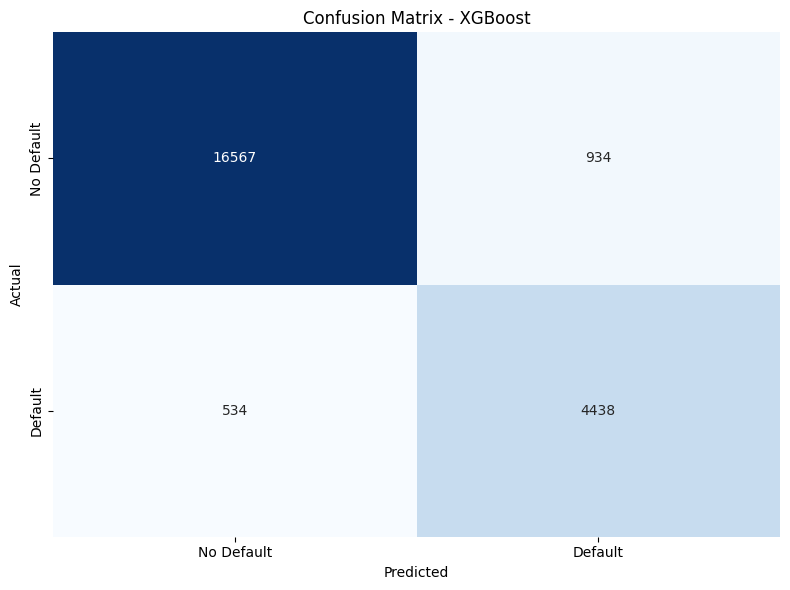

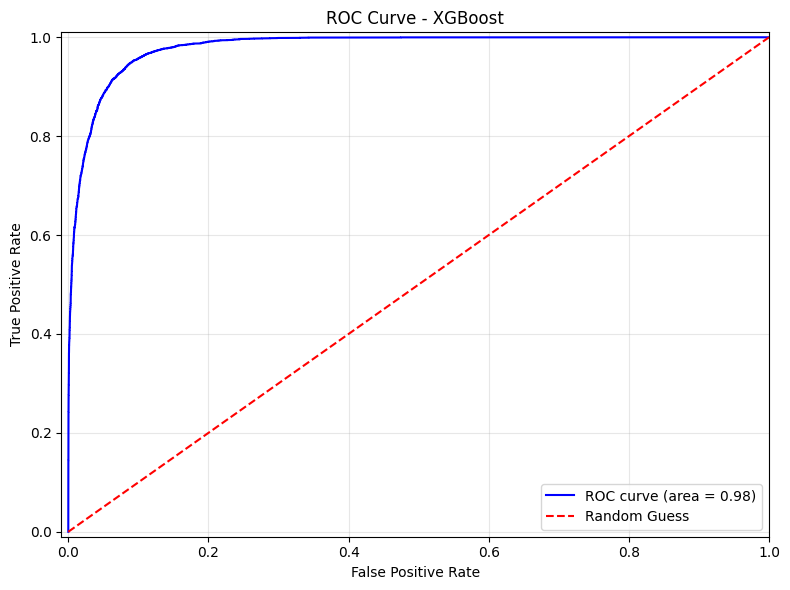

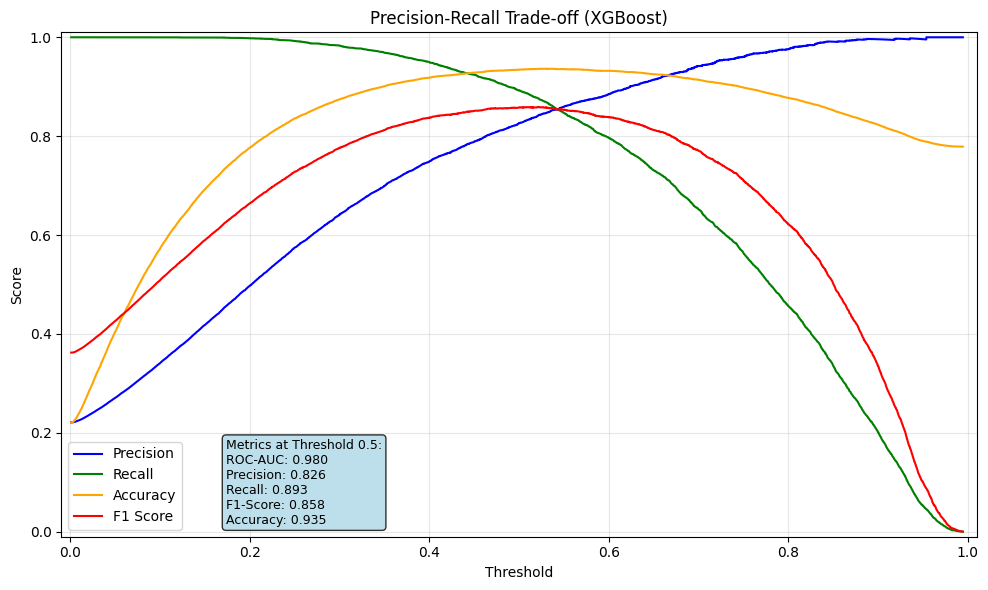

In [52]:
# Getting predicted probabilities for positive (Default) class
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Plotting the confusion matrix for XGBoost Classifier
plot_confusion_matrix(cm_xgb, model_name='XGBoost', save_path=test_performace_outputs)

# Plotting the ROC curve for XGBoost Classifier
plot_roc_curve(y_test, y_pred_proba_xgb, model_name='XGBoost', save_path=test_performace_outputs)

# Plotting the Precision-Recall Trade-off for XGBoost Classifier
plot_precision_recall_tradeoff(y_test, y_pred_proba_xgb, y_pred_xgb, model_name='XGBoost', save_path=test_performace_outputs)

- XGBoost Classifier performs very well with Area Under ROC Curve (AUC) of 98% and F1 score of 85% on test dataset.
- The model has a precision of 82.6%, which means that when the model predicts a default payment, it is correct 82.6% of the time.
- The recall is 89.3%, indicating that the model identifies 89.3% of actual default payments, which is significantly better than both Random Forest and Gradient Boosting Classifiers.

## **Performance comparison of all models on test dataset**

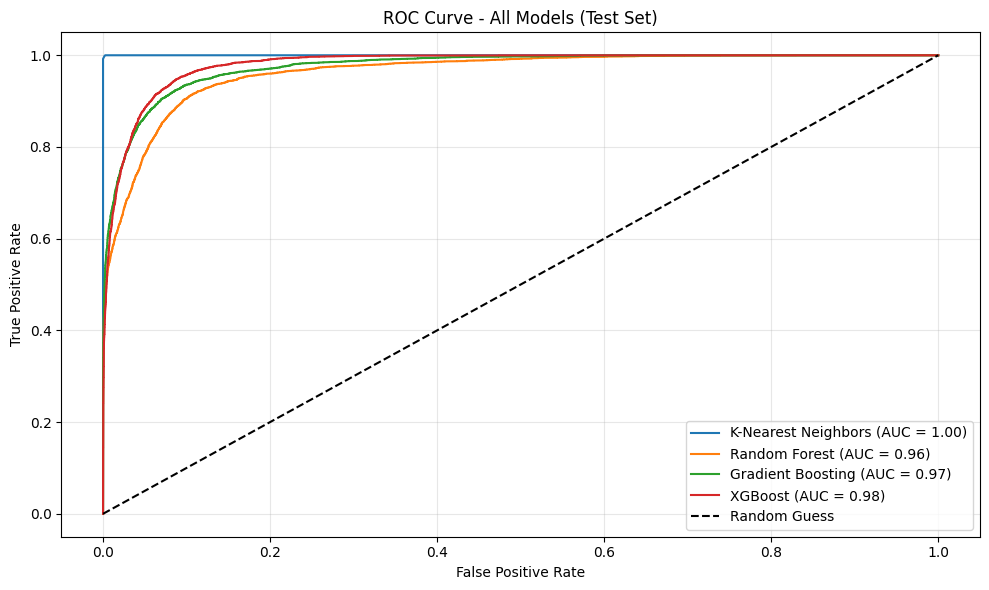

In [53]:
# Calculating fpr, tpr, and roc_auc for all models on the test set
fpr_knn, tpr_knn, roc_auc_knn = calculate_roc_auc(y_test, y_pred_proba_knn)
fpr_rf, tpr_rf, roc_auc_rf = calculate_roc_auc(y_test, y_pred_proba_rf)
fpr_gb, tpr_gb, roc_auc_gb = calculate_roc_auc(y_test, y_pred_proba_gb)
fpr_xgb, tpr_xgb, roc_auc_xgb = calculate_roc_auc(y_test, y_pred_proba_xgb)


# Plotting ROC AUC for all models on the test set
plt.figure(figsize=(10, 6))
plt.plot(fpr_knn, tpr_knn, label=f'K-Nearest Neighbors (AUC = {roc_auc_knn:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_gb, tpr_gb, label=f'Gradient Boosting (AUC = {roc_auc_gb:.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - All Models (Test Set)')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(test_performace_outputs, "roc_curve_all_models_comparison.png"))
plt.show()

- Based on the Area Under ROC Curve (AUC) all models performed well on test dataset with KNN Classifier (100%), XGBoost Classifier (98%), Gradient Boosting Classifier (97%) and Random Forest Classifier (96%).

In [57]:
# Creating a summary dataframe for model performance on the test set
model_performance_test = {
    'Model': ['K-Nearest Neighbors', 'Random Forest', 'Gradient Boosting', 'XGBoost'],
    'ROC AUC': [roc_auc_knn, roc_auc_rf, roc_auc_gb, roc_auc_xgb],
    'Precision': [precision_knn, precision_rf, precision_gb, precision_xgb],
    'Recall': [recall_knn, recall_rf, recall_gb, recall_xgb],
    'F1 Score': [f1_knn, f1_rf, f1_gb, f1_xgb],
    'Accuracy': [accuracy_knn, accuracy_rf, accuracy_gb, accuracy_xgb]
}

model_performance_test_df = pd.DataFrame(model_performance_test)
model_performance_test_df = model_performance_test_df.round(3).sort_values(by='ROC AUC', ascending=False, ignore_index=True)

# Saving the model performance summary for the test set to a CSV file
model_performance_test_df.to_csv(os.path.join(csv_output_dir, "model_performance_summary_test.csv"), index=False)

# Displaying the model performance summary for the test set
model_performance_test_df

,Model,ROC AUC,Precision,Recall,F1 Score,Accuracy
0,K-Nearest Neighbors,1.000,0.999,0.993,0.996,0.998
1,XGBoost,0.980,0.826,0.893,0.858,0.935
2,Gradient Boosting,0.975,0.918,0.733,0.815,0.926
3,Random Forest,0.963,0.862,0.699,0.772,0.909


- Based on the performance metrics, the KNN Classifier has shown the best performance on test dataset with AUC of 100%, F1 score of 99.6%, precision of 99.9% and recall of 99.3%. It has generalized well to unseen data. 
- XGBoost Classifier also performed well with AUC of 98%, F1 score of 85.8%, precision of 82.6% and recall of 89.3%. It has also generalized well to unseen data.
- Gradient Boosting Classifier and Random Forest Classifier also performed well with AUC of 97.5% and 96.3% respectively, but their recall is significantly lower than KNN Classifier and XGBoost Classifier.

## **Model Selection**
- Based on the performance metrics, we will select **KNN Classifier** and **XGBoost Classifier** as the final models for credit card default prediction. KNN Classifier has shown the best performance on test dataset with AUC of 100%, F1 score of 99.6%, precision of 99.9% and recall of 99.3%. XGBoost Classifier also performed well with AUC of 98%, F1 score of 85.8%, precision of 82.6% and recall of 89.3%. Both models have generalized well to unseen data.